### 1. Using Keras Datasets, obtain the fMNIST data set. Explore and describe it as you would do with any new dataset that you start working with (2 points).


In [2]:
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
import keras
import seaborn as sns; 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker


2023-07-21 14:24:27.128042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = fetch_openml('Fashion-MNIST', as_frame=False, parser='auto')

In [4]:
list(data)

['data',
 'target',
 'frame',
 'categories',
 'feature_names',
 'target_names',
 'DESCR',
 'details',
 'url']

In [5]:
print(data.DESCR)

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Description  
0  T-shirt/top  
1  Trouser  
2  Pullover  
3  Dress  
4  

In [6]:
data.data.shape

(70000, 784)

In [7]:
data.target.shape

(70000,)

In [8]:
X = data.data
y = to_categorical(data.target)

In [9]:
def plot_image(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

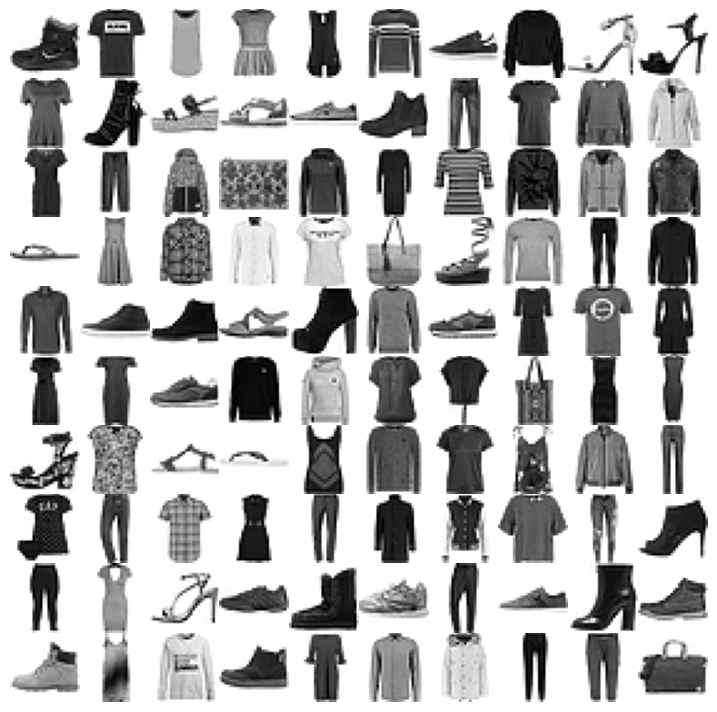

In [10]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_image(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### 2. Train a dense neural network using Keras

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

X_train = X_train.reshape((60000, 28 * 28))  # flattening the 28x28 image into dim=1 (784,) vector (and over all images in the training set)
X_test = X_test.reshape((10000, 28 * 28))

X_train = X_train.astype("float32") / 255  # normalizing the data to the range [0,1] by min-max range, and casting it to float32
X_test = X_test.astype("float32") / 255

In [12]:
def make_model(model_params):
    model = Sequential()

    if len(model_params['layers']) == 0:
        model.add(Dense(model_params['output'], input_dim=model_params['input'], activation='softmax'))

    else:
        model.add(Dense(model_params['layers'][-1], input_dim=model_params['input'], activation='relu'))
        
        for i in range(len(model_params['layers']) - 1):
            model.add(Dense(i, activation='relu'))

        model.add(Dense(10, activation='softmax'))

    return model
        

In [13]:
def fit_model(model, epochs, batch_size, verbose):
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model, history

In [14]:

def one_hot_to_label(one_hot):
    label = list()

    for i in range(len(one_hot)):
        label.append(np.argmax(one_hot[i]))

    return label

In [15]:
def evaluate_model(y_test, y_pred, labels):
  y_pred = one_hot_to_label(y_pred)
  y_test = one_hot_to_label(y_test)
  cm = confusion_matrix(y_test, y_pred)
  cr = classification_report(y_test, y_pred)

  
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  print(cr)
  plt.show()
  return cm, cr

In [16]:
def evaluate_histories(histories, models, figsize):
    _,(ax1,ax2)=plt.subplots(2,figsize=figsize)

    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for i in range(len(histories)):
        val_acc = histories[i].history['accuracy']
        val_loss = histories[i].history['loss']
        ax1.plot(val_acc, label=models[i])
        ax2.plot(val_loss, label=models[i])
    ax1.set_ylabel('Accuracy')
    ax2.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    ax2.set_xlabel('Epochs')
    ax1.legend()
    ax2.legend()
    plt.show()  

In [17]:
def build_and_evaluate_model(model_params):
    model = make_model(model_params)
    model, history = fit_model(model,model_params['epochs'], model_params['batch_size'], model_params['verbose'] )
    y_pred = model.predict(X_test, verbose=0)
    cm, cr = evaluate_model(y_test, y_pred, model_params['labels'])
    return history, cm, cr

In [18]:
def classification_report_to_df(cr):
    cr_data = [x.split() for x in cr.split('\n')]
    cr_df = pd.DataFrame(columns=cr_data[0][:-1])
    for data in cr_data[2:12]:
        data_df = pd.DataFrame([data[1:-1]], columns=cr_data[0][:-1])   
        cr_df = pd.concat([cr_df, data_df], ignore_index=True)

    return(cr_df)

In [19]:
def evaluate_classification_reports(cr_array):
    df = pd.DataFrame()

    for i in range(len(cr_array)):
        cr_df = classification_report_to_df(cr_array[i])[3:]
        cr_df.index = cr_df.index + 1
        cr_df = cr_df.stack()
        cr_df.index = cr_df.index.map('{0[1]}_{0[0]}'.format)
        cr_df = cr_df.to_frame().T
        df = pd.concat([df, cr_df], ignore_index=True)

    object_columns = df.columns[df.dtypes.eq(object)]
    df[object_columns] = df[object_columns].apply(
        pd.to_numeric,
        errors='coerce',
        axis=0
    )

    df_min = pd.DataFrame(df).T
    df_max = pd.DataFrame(df.idxmax()).value_counts()

    best_model = df_max.T.idxmax()[0]
    stable_model = df_min.min().idxmax()

    return best_model, stable_model

In [20]:
def build_and_evaluate_models(models):
    params = {
        'labels': ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],
        'epochs': 5,
        'batch_size': 128,
        'input': 784,
        'output': 10,
        'verbose': 0
    }

    model_results = {
        'models': models,
        'history_array':[],
        'cm_array':[],
        'cr_array':[]
    }

    for model in models:
        print(model)
        params['layers'] = model
        history, confusion_matrix, classification_report, = build_and_evaluate_model(params)
        model_results['history_array'].append(history)
        model_results['cm_array'].append(confusion_matrix)
        model_results['cr_array'].append(classification_report)
        
    evaluate_histories(model_results['history_array'], models, (8, 100))
    return evaluate_classification_reports(model_results['cr_array'])

In [21]:
def make_model_threading(layers, input, output):
    model = Sequential()

    if len(layers) == 0:
        model.add(Dense(output, input_dim=input, activation='softmax'))

    else:
        model.add(Dense(layers[-1], input_dim=input, activation='relu'))
        
        for i in range(len(layers) - 1):
            model.add(Dense(i, activation='relu'))

        model.add(Dense(10, activation='softmax'))

    return model

In [22]:
def build_and_evaluate_model_threading(epochs, batch_size, input, output, verbose, layers, result, index):
    model = make_model_threading(layers, input, output)
    model, history = fit_model(model,epochs, batch_size, verbose)
    y_pred = model.predict(X_test, verbose=0)
    result[index] = {'history': history, 'y_test': y_test, 'y_pred': y_pred, 'labels': y_pred}
    print('Done:', layers)

In [29]:
from threading import Thread
def build_and_evaluate_models_threading(models):
    
    labels =  ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    epochs =  25
    batch_size =  128
    input =  784
    output =  10
    verbose =  0


    model_results = {
        'models': models,
        'history_array':[],
        'cm_array':[],
        'cr_array':[]
    }

    threads = [None] * len(models)
    results = [None] * len(models)

    for i in range(len(threads)):
        threads[i] = Thread(target=build_and_evaluate_model_threading, args=(epochs, batch_size, input, output, verbose, models[i], results, i))
        threads[i].start()

    for i in range(len(threads)):
        threads[i].join()

    for i in range(len(results)):
        print(models[i])
        cm, cr = evaluate_model(y_test, results[i]['y_pred'], labels)

        model_results['history_array'].append(results[i]['history'])
        model_results['cm_array'].append(cm)
        model_results['cr_array'].append(cr)
        
    evaluate_histories(model_results['history_array'], models, (8, 100))
    return evaluate_classification_reports(model_results['cr_array'])

[20, 10]


/home/billy/src/FML/CSCN8010/venv/tensorflow_cpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/billy/src/FML/CSCN8010/venv/tensorflow_cpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/billy/src/FML/CSCN8010/venv/tensorflow_cpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.10      1.00      0.18      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



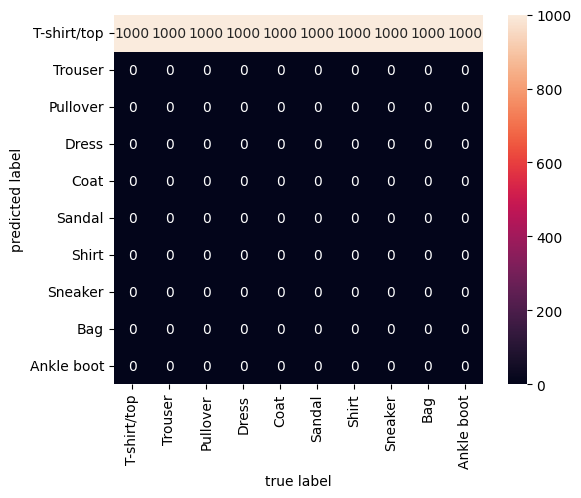

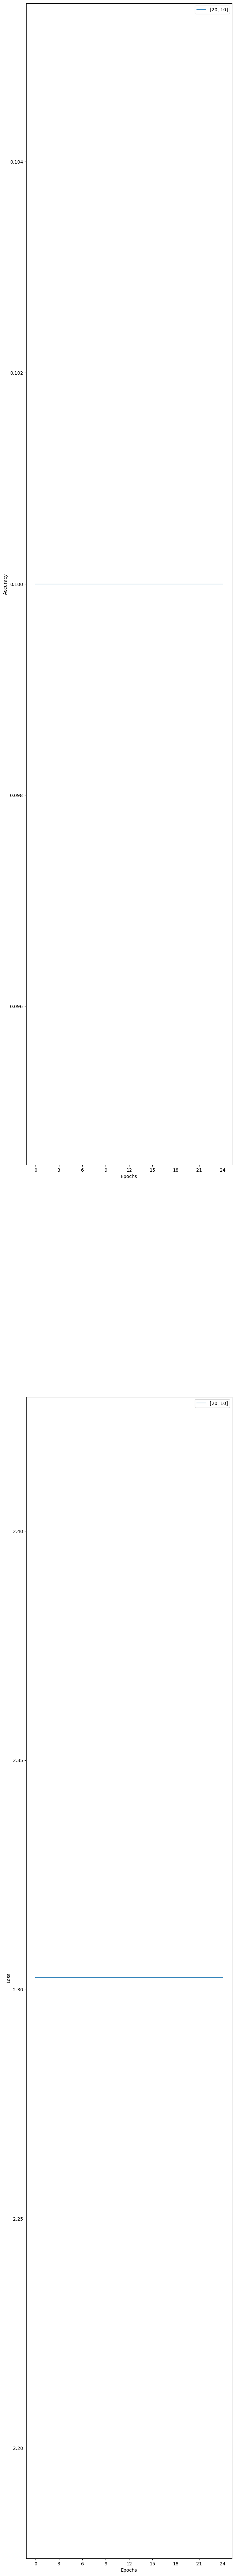

Best model:  [20, 10]
Stable model:  [20, 10]


In [40]:
models = [[20, 10]]

best_model, stable_model = build_and_evaluate_models_threading(models)
print('Best model: ', models[best_model])
print('Stable model: ', models[stable_model])

[10]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.99      0.95      0.97      1000
           2       0.73      0.77      0.75      1000
           3       0.82      0.86      0.84      1000
           4       0.78      0.69      0.73      1000
           5       0.95      0.92      0.93      1000
           6       0.62      0.62      0.62      1000
           7       0.91      0.94      0.92      1000
           8       0.95      0.94      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



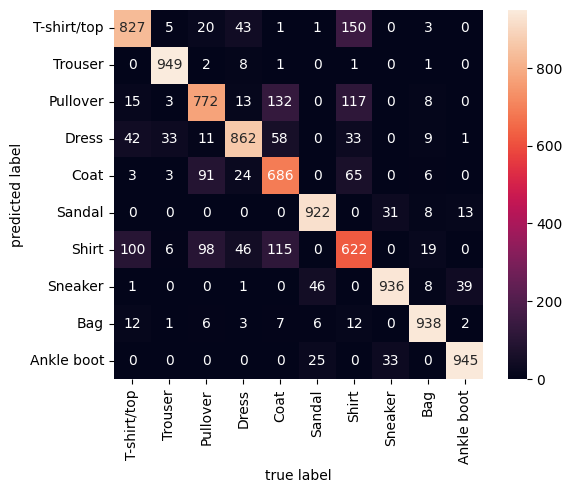

[20]
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      1000
           1       0.97      0.96      0.97      1000
           2       0.71      0.83      0.76      1000
           3       0.92      0.79      0.85      1000
           4       0.77      0.79      0.78      1000
           5       0.97      0.94      0.96      1000
           6       0.74      0.55      0.63      1000
           7       0.93      0.94      0.94      1000
           8       0.98      0.95      0.96      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



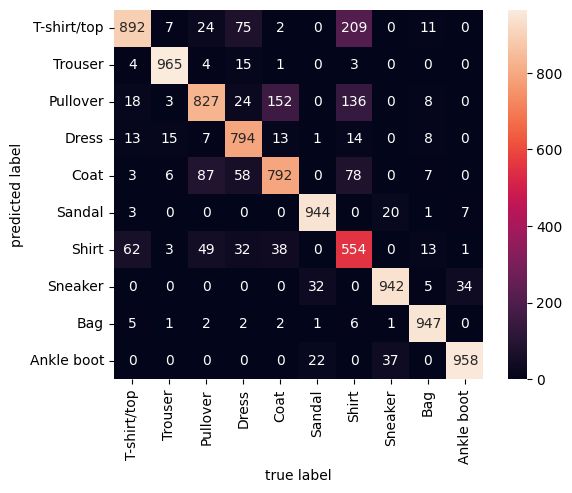

[30]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1000
           1       0.93      0.98      0.95      1000
           2       0.67      0.88      0.76      1000
           3       0.87      0.87      0.87      1000
           4       0.80      0.74      0.77      1000
           5       0.96      0.96      0.96      1000
           6       0.79      0.49      0.61      1000
           7       0.95      0.91      0.93      1000
           8       0.96      0.96      0.96      1000
           9       0.92      0.97      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



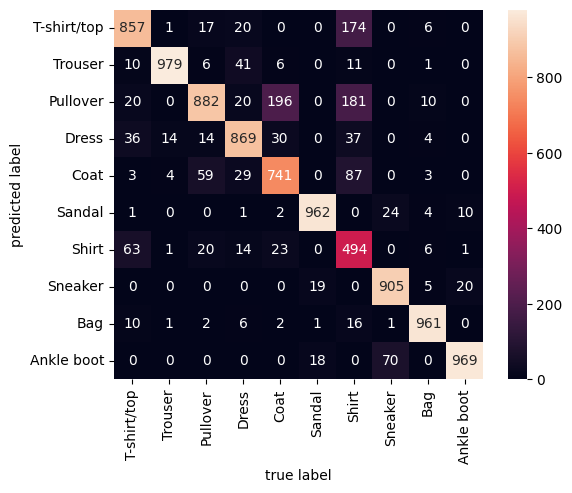

[40]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.75      0.80      0.78      1000
           3       0.83      0.92      0.87      1000
           4       0.72      0.86      0.78      1000
           5       0.96      0.97      0.97      1000
           6       0.79      0.52      0.62      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.96      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



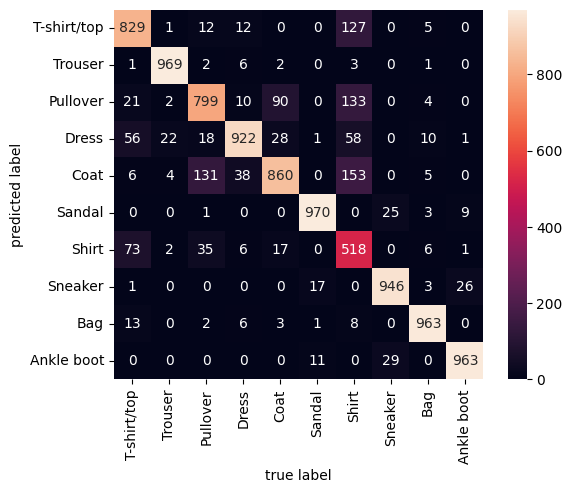

[50]
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.99      0.98      0.98      1000
           2       0.87      0.64      0.74      1000
           3       0.81      0.94      0.87      1000
           4       0.70      0.86      0.77      1000
           5       0.94      0.98      0.96      1000
           6       0.74      0.65      0.69      1000
           7       0.93      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.92      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



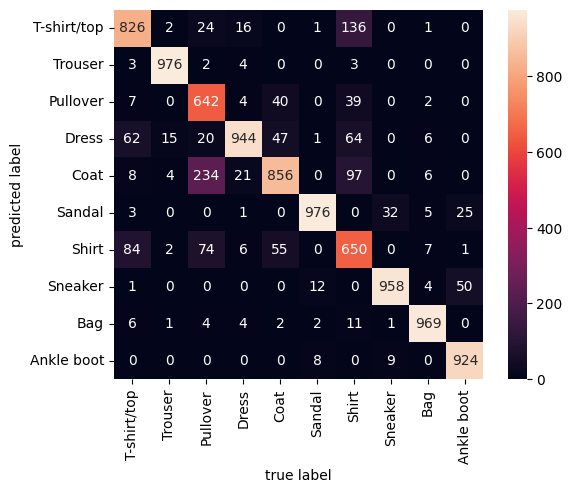

[60]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.84      0.69      0.76      1000
           3       0.92      0.84      0.88      1000
           4       0.71      0.88      0.79      1000
           5       0.97      0.96      0.96      1000
           6       0.67      0.73      0.70      1000
           7       0.93      0.96      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



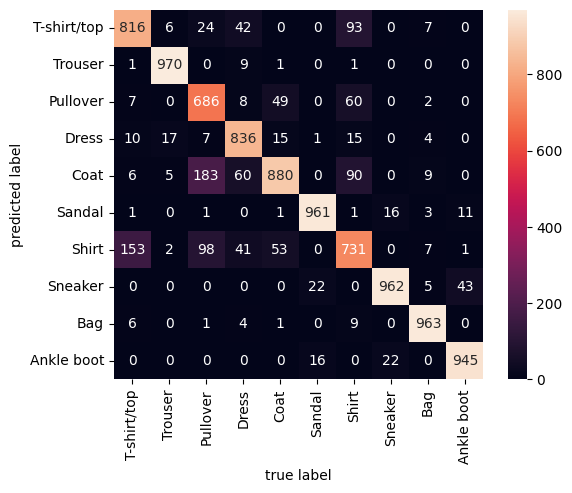

[70]
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.74      0.78      1000
           3       0.86      0.91      0.88      1000
           4       0.80      0.78      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.63      0.80      0.70      1000
           7       0.92      0.98      0.95      1000
           8       0.98      0.95      0.96      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



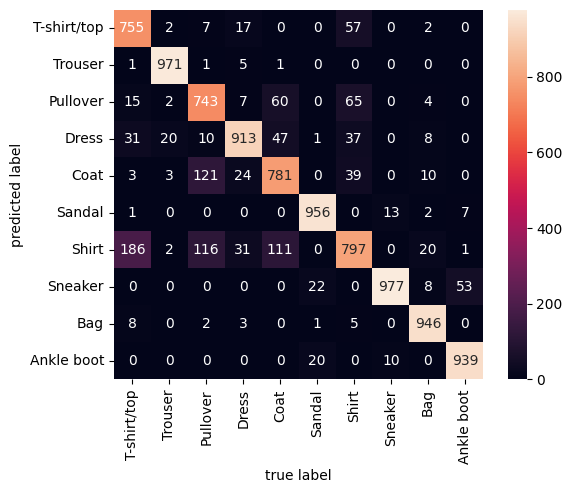

[80]
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.85      0.81      1000
           3       0.86      0.92      0.89      1000
           4       0.83      0.79      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.75      0.67      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



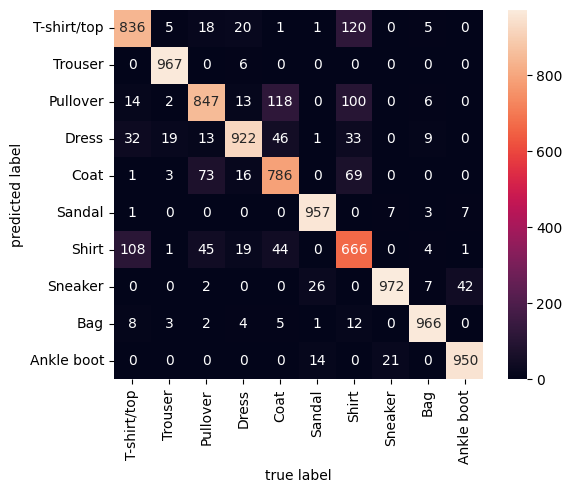

[90]
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1000
           1       0.99      0.98      0.98      1000
           2       0.76      0.83      0.79      1000
           3       0.93      0.84      0.88      1000
           4       0.79      0.80      0.80      1000
           5       0.98      0.97      0.97      1000
           6       0.74      0.65      0.70      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.95      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



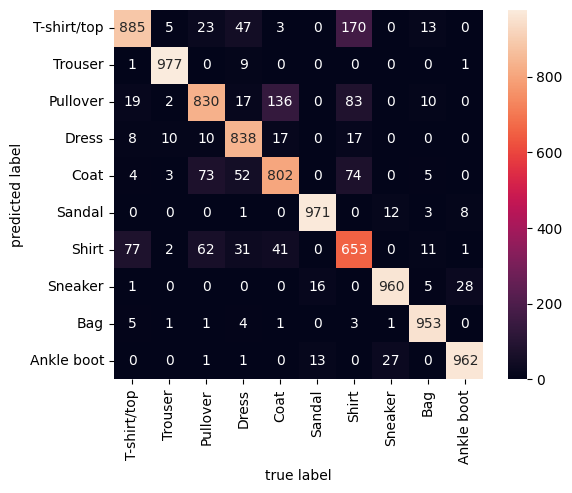

[100]
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.77      0.84      0.80      1000
           3       0.87      0.92      0.90      1000
           4       0.86      0.72      0.79      1000
           5       0.98      0.95      0.97      1000
           6       0.70      0.73      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



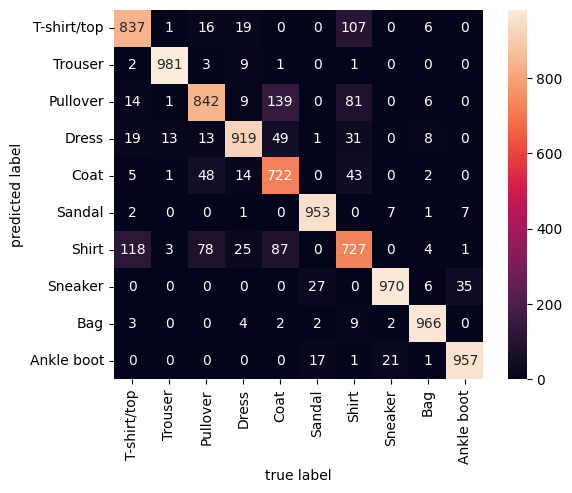

[110]
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1000
           1       0.97      0.98      0.98      1000
           2       0.63      0.91      0.75      1000
           3       0.88      0.91      0.89      1000
           4       0.82      0.71      0.76      1000
           5       0.97      0.96      0.96      1000
           6       0.78      0.58      0.66      1000
           7       0.95      0.96      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



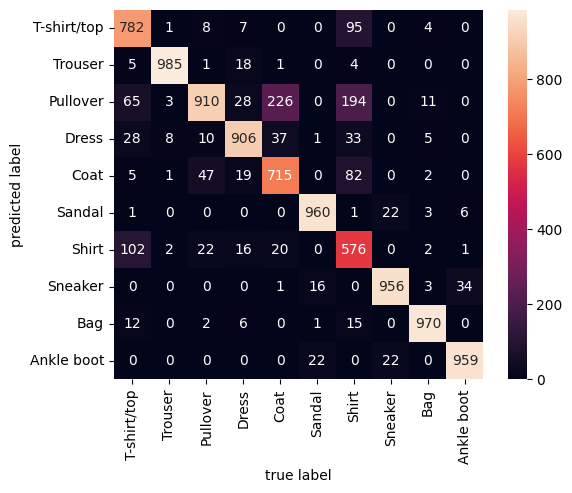

[120]
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.69      0.76      1000
           3       0.90      0.87      0.89      1000
           4       0.66      0.93      0.77      1000
           5       0.97      0.97      0.97      1000
           6       0.76      0.65      0.70      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



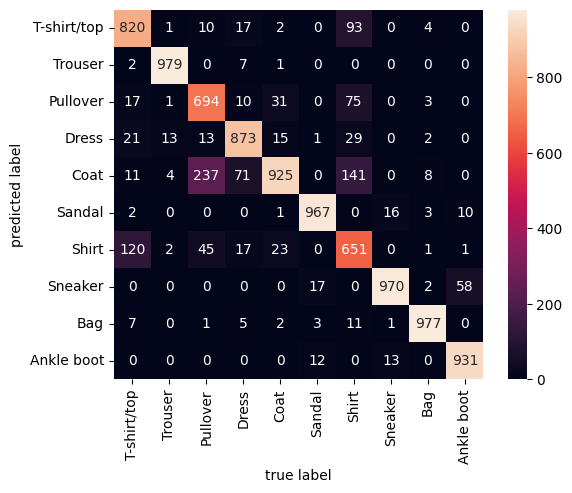

[130]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       1.00      0.97      0.98      1000
           2       0.81      0.81      0.81      1000
           3       0.88      0.91      0.89      1000
           4       0.76      0.85      0.80      1000
           5       0.98      0.94      0.96      1000
           6       0.77      0.65      0.71      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



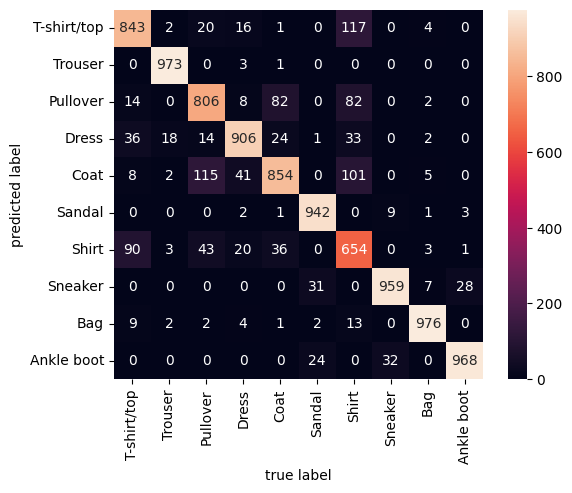

[140]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1000
           1       0.98      0.99      0.98      1000
           2       0.87      0.73      0.80      1000
           3       0.95      0.82      0.88      1000
           4       0.78      0.79      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.65      0.76      0.70      1000
           7       0.96      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.98      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



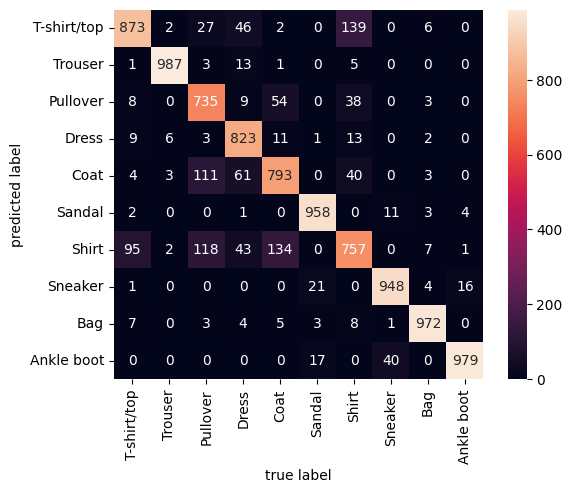

[150]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.80      0.82      0.81      1000
           3       0.88      0.92      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.69      0.71      1000
           7       0.91      0.98      0.95      1000
           8       0.99      0.95      0.97      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



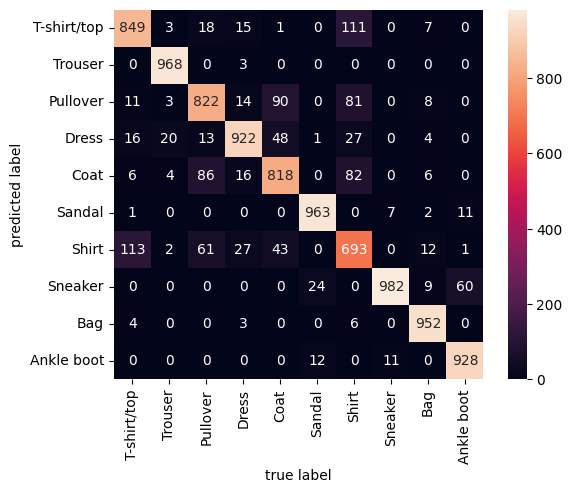

[160]
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.85      0.72      0.78      1000
           3       0.88      0.92      0.90      1000
           4       0.76      0.87      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.67      0.75      0.71      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



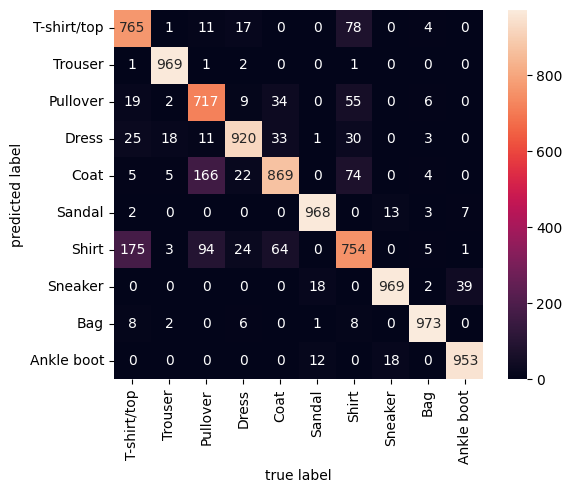

[170]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1000
           1       1.00      0.96      0.98      1000
           2       0.75      0.87      0.80      1000
           3       0.88      0.91      0.89      1000
           4       0.84      0.76      0.80      1000
           5       0.96      0.98      0.97      1000
           6       0.71      0.69      0.70      1000
           7       0.93      0.97      0.95      1000
           8       0.99      0.95      0.97      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



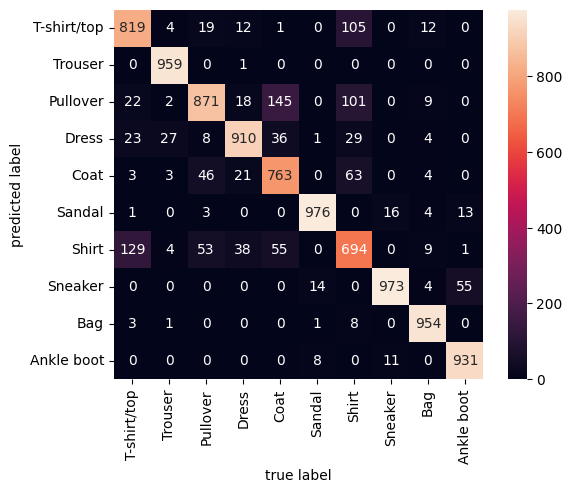

[180]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1000
           1       0.99      0.98      0.98      1000
           2       0.88      0.68      0.76      1000
           3       0.94      0.85      0.89      1000
           4       0.83      0.77      0.80      1000
           5       0.98      0.97      0.98      1000
           6       0.54      0.85      0.66      1000
           7       0.93      0.98      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.88     10000
weighted avg       0.89      0.87      0.88     10000



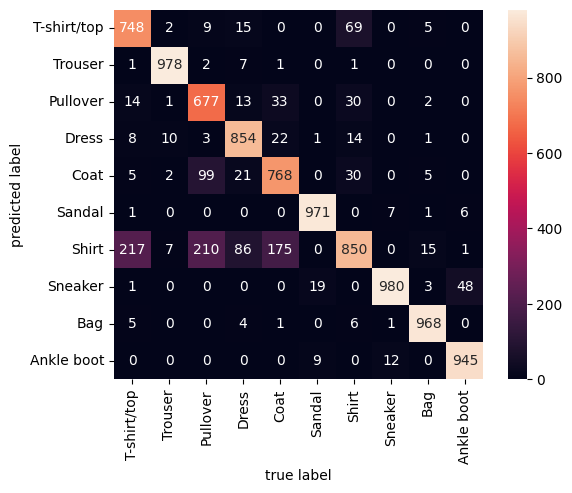

[190]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       1.00      0.96      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.86      0.93      0.89      1000
           4       0.80      0.83      0.81      1000
           5       0.98      0.95      0.97      1000
           6       0.75      0.64      0.69      1000
           7       0.94      0.96      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



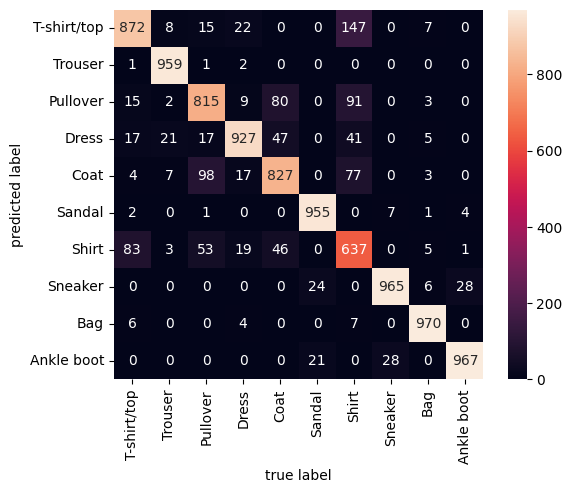

[200]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1000
           1       0.97      0.98      0.98      1000
           2       0.80      0.83      0.81      1000
           3       0.94      0.83      0.88      1000
           4       0.81      0.83      0.82      1000
           5       0.97      0.98      0.97      1000
           6       0.69      0.73      0.71      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



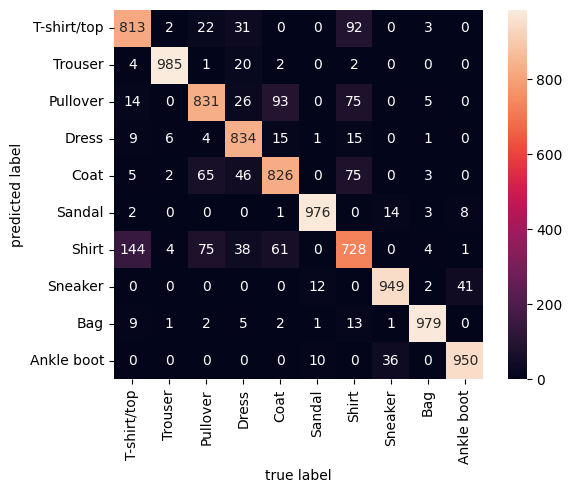

[210]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.87      0.73      0.79      1000
           3       0.91      0.89      0.90      1000
           4       0.73      0.89      0.80      1000
           5       0.98      0.97      0.97      1000
           6       0.75      0.71      0.73      1000
           7       0.95      0.96      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



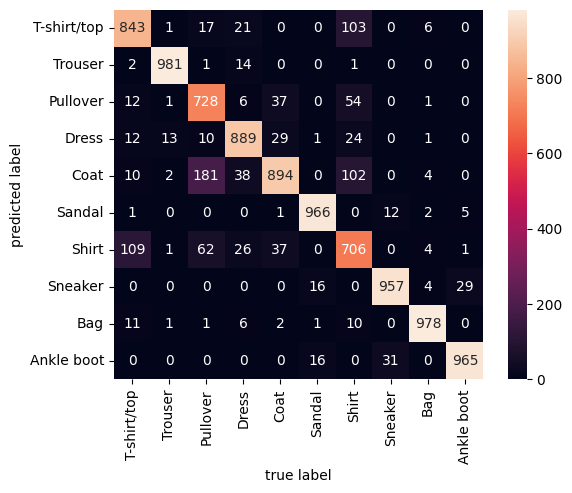

[220]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.87      0.93      0.90      1000
           4       0.81      0.82      0.81      1000
           5       0.94      0.98      0.96      1000
           6       0.78      0.65      0.71      1000
           7       0.98      0.90      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.93      0.98      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



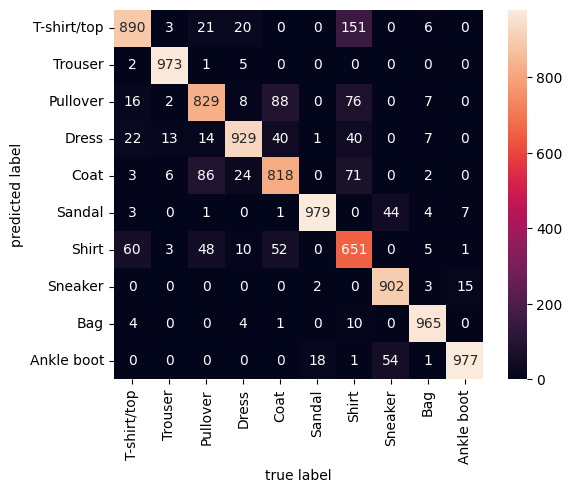

[230]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.81      0.77      0.79      1000
           3       0.89      0.92      0.90      1000
           4       0.79      0.83      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.74      0.69      0.72      1000
           7       0.95      0.97      0.96      1000
           8       0.96      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



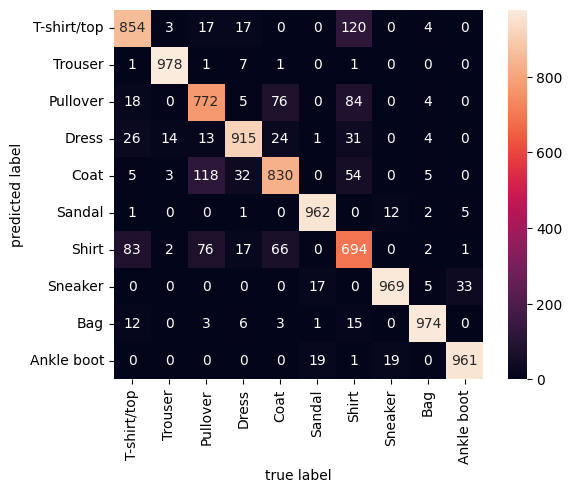

[240]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.77      0.80      1000
           3       0.88      0.94      0.91      1000
           4       0.75      0.88      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.74      0.68      0.71      1000
           7       0.89      0.99      0.94      1000
           8       0.98      0.97      0.97      1000
           9       0.98      0.90      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



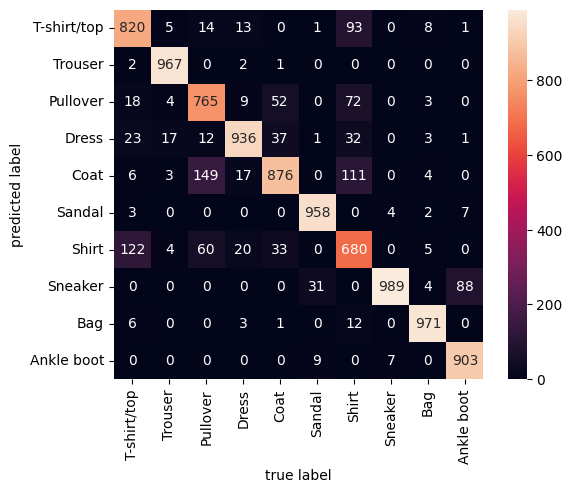

[250]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.79      0.79      0.79      1000
           3       0.90      0.91      0.91      1000
           4       0.91      0.68      0.78      1000
           5       0.98      0.97      0.97      1000
           6       0.60      0.81      0.69      1000
           7       0.96      0.94      0.95      1000
           8       0.99      0.95      0.97      1000
           9       0.94      0.98      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



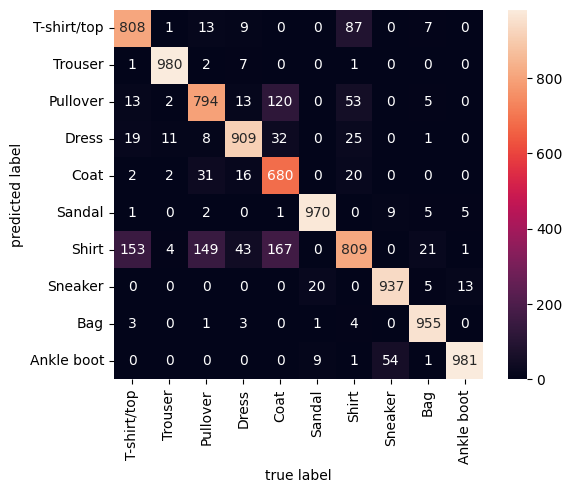

[260]
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.71      0.78      1000
           3       0.90      0.91      0.91      1000
           4       0.80      0.83      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.61      0.80      0.69      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.96      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



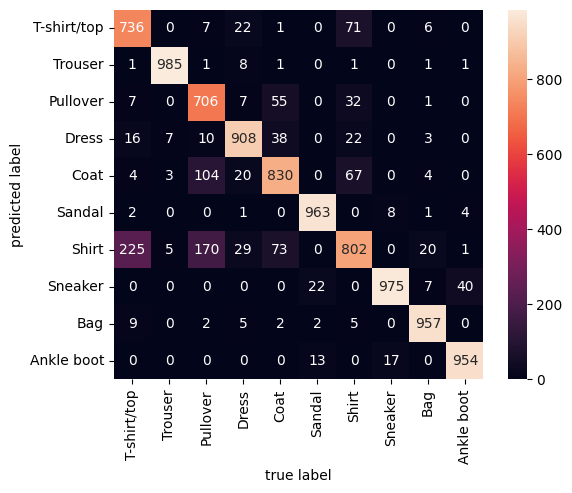

[270]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.60      0.93      0.73      1000
           3       0.85      0.93      0.89      1000
           4       0.87      0.62      0.73      1000
           5       0.99      0.95      0.97      1000
           6       0.86      0.51      0.64      1000
           7       0.95      0.94      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



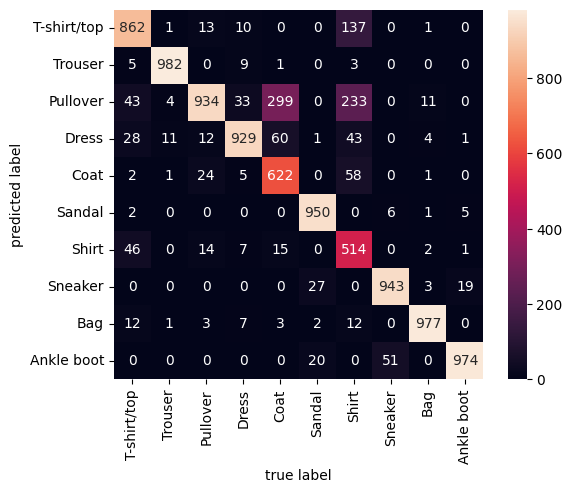

[280]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.88      0.92      0.90      1000
           4       0.79      0.81      0.80      1000
           5       0.97      0.97      0.97      1000
           6       0.71      0.73      0.72      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



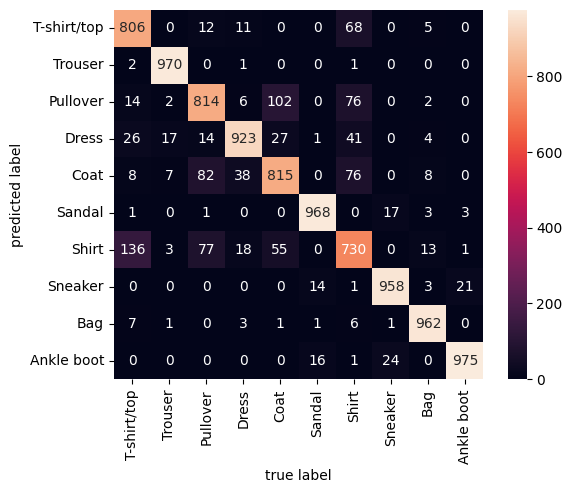

[290]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.65      0.91      0.76      1000
           3       0.94      0.83      0.88      1000
           4       0.83      0.71      0.77      1000
           5       0.98      0.96      0.97      1000
           6       0.76      0.64      0.69      1000
           7       0.93      0.97      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



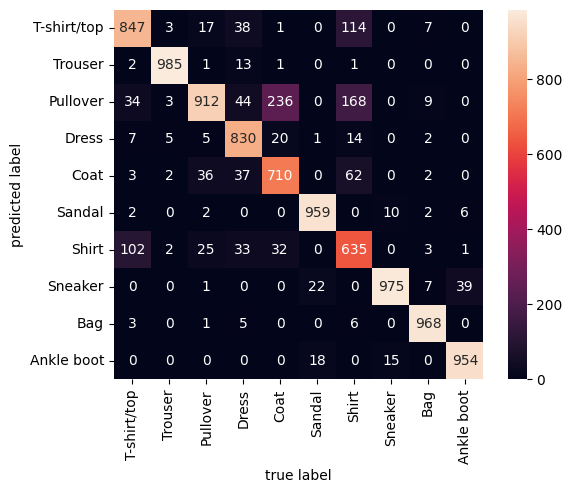

[300]
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.88      0.72      0.79      1000
           3       0.92      0.88      0.90      1000
           4       0.76      0.86      0.81      1000
           5       0.98      0.97      0.97      1000
           6       0.67      0.76      0.71      1000
           7       0.95      0.96      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



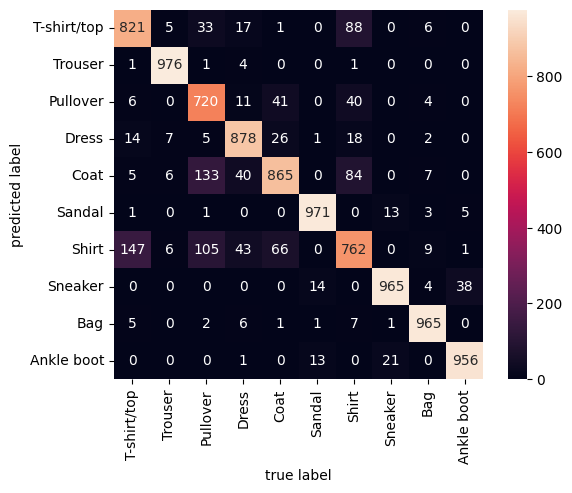

[310]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.74      0.85      0.79      1000
           3       0.89      0.91      0.90      1000
           4       0.81      0.76      0.78      1000
           5       0.98      0.97      0.97      1000
           6       0.71      0.70      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



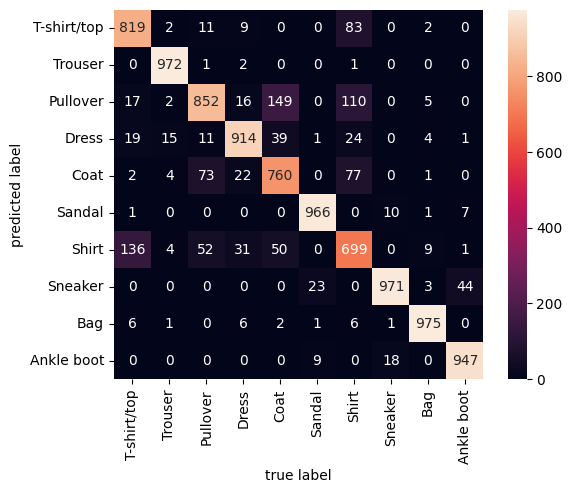

[320]
              precision    recall  f1-score   support

           0       0.88      0.79      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.73      0.79      1000
           3       0.90      0.91      0.90      1000
           4       0.80      0.83      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.66      0.78      0.71      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



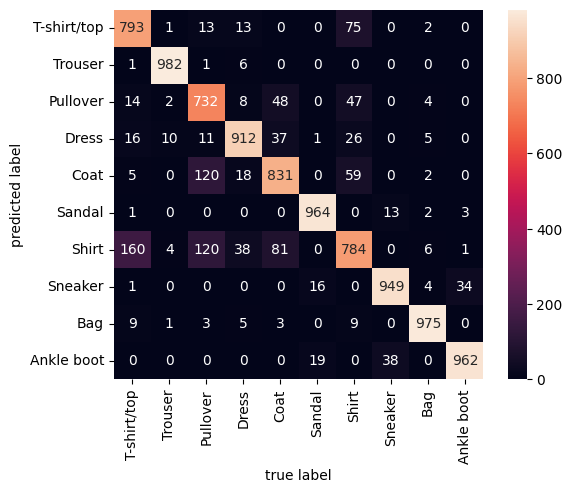

[330]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1000
           1       1.00      0.97      0.98      1000
           2       0.83      0.79      0.80      1000
           3       0.86      0.94      0.90      1000
           4       0.85      0.77      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.68      0.70      1000
           7       0.88      0.99      0.93      1000
           8       0.99      0.96      0.97      1000
           9       0.99      0.89      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



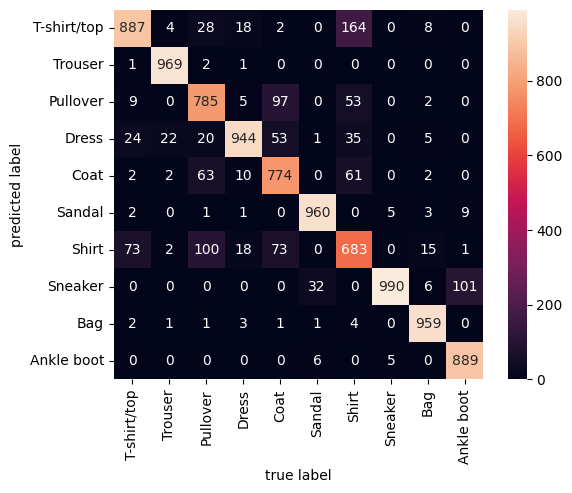

[340]
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.78      0.83      0.80      1000
           3       0.87      0.93      0.90      1000
           4       0.82      0.80      0.81      1000
           5       0.99      0.96      0.97      1000
           6       0.71      0.72      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



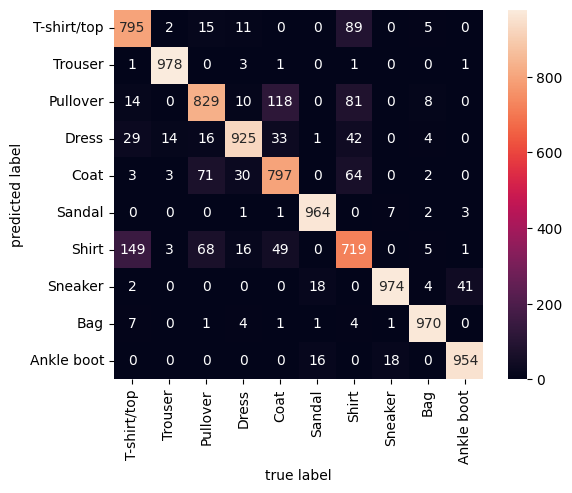

[350]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.79      0.83      0.81      1000
           3       0.85      0.94      0.89      1000
           4       0.85      0.78      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.75      0.74      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



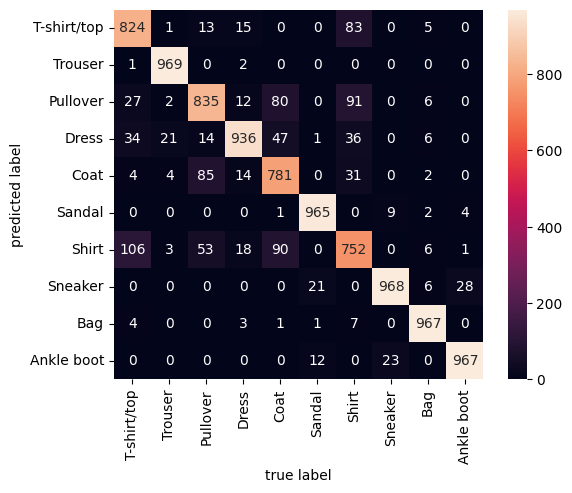

[360]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.80      0.81      1000
           3       0.85      0.93      0.89      1000
           4       0.78      0.84      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.78      0.61      0.69      1000
           7       0.94      0.97      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



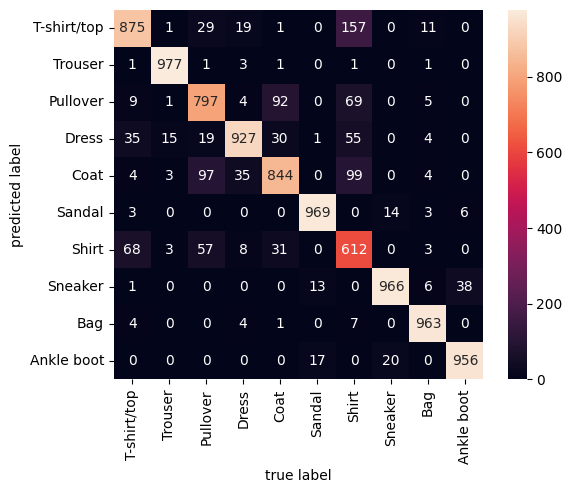

[370]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.80      0.80      1000
           3       0.87      0.93      0.90      1000
           4       0.79      0.81      0.80      1000
           5       0.97      0.97      0.97      1000
           6       0.75      0.66      0.70      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



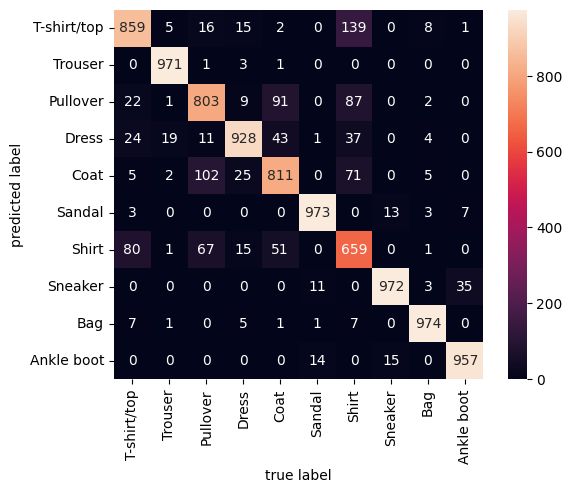

[380]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.78      0.81      0.80      1000
           3       0.91      0.90      0.91      1000
           4       0.76      0.87      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.78      0.66      0.72      1000
           7       0.95      0.94      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



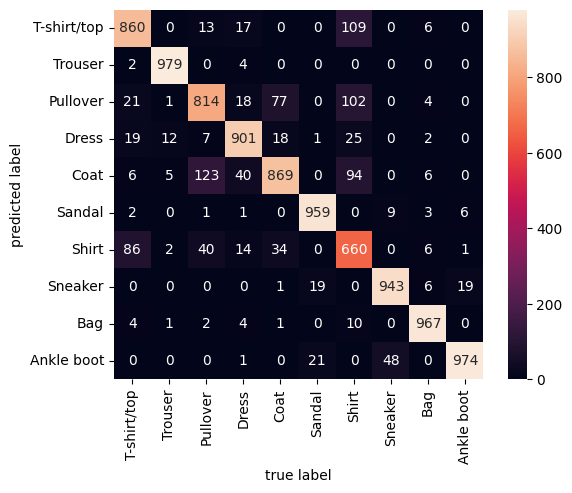

[390]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.75      0.87      0.81      1000
           3       0.92      0.87      0.89      1000
           4       0.83      0.76      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.79      0.62      0.70      1000
           7       0.93      0.98      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



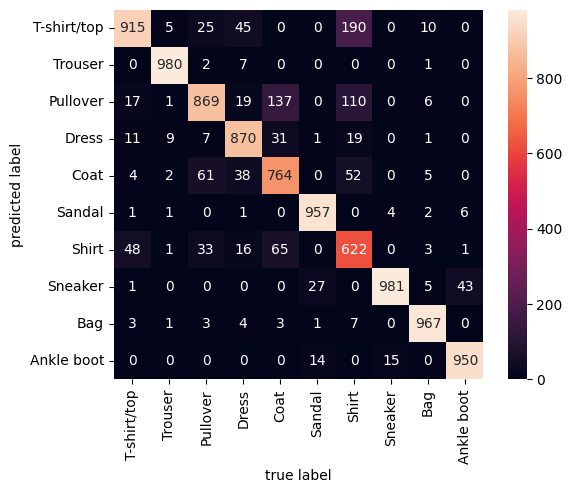

[400]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.81      0.82      0.81      1000
           3       0.88      0.92      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.71      0.72      0.71      1000
           7       0.96      0.95      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



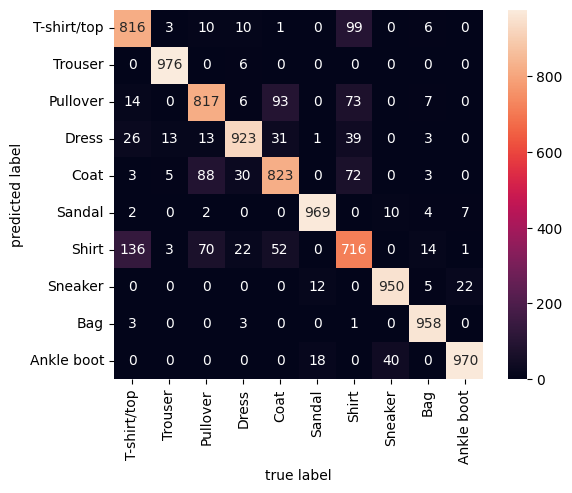

[410]
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.83      0.79      0.81      1000
           3       0.92      0.89      0.90      1000
           4       0.78      0.86      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.79      0.60      0.68      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



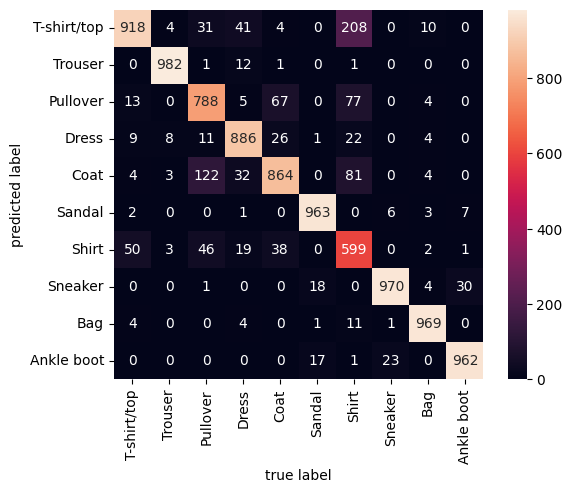

[420]
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.72      0.90      0.80      1000
           3       0.91      0.88      0.89      1000
           4       0.80      0.81      0.80      1000
           5       0.98      0.97      0.98      1000
           6       0.72      0.68      0.70      1000
           7       0.92      0.98      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



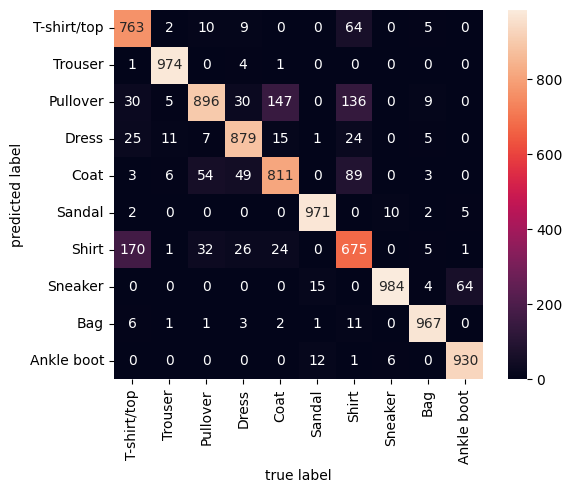

[430]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.75      0.87      0.80      1000
           3       0.85      0.95      0.89      1000
           4       0.85      0.74      0.79      1000
           5       0.98      0.98      0.98      1000
           6       0.78      0.63      0.70      1000
           7       0.95      0.96      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



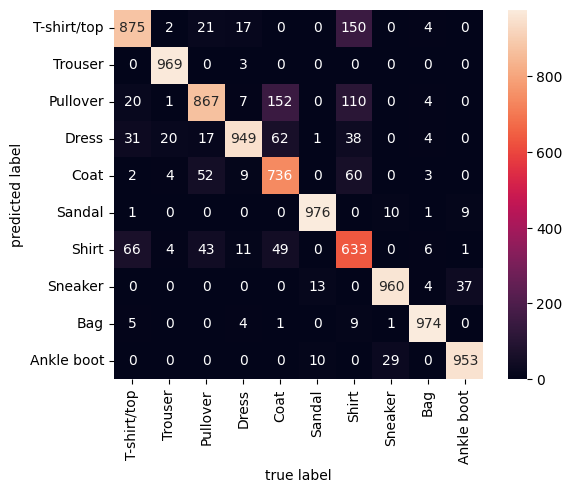

[440]
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.86      0.69      0.77      1000
           3       0.89      0.90      0.89      1000
           4       0.80      0.83      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.64      0.80      0.71      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



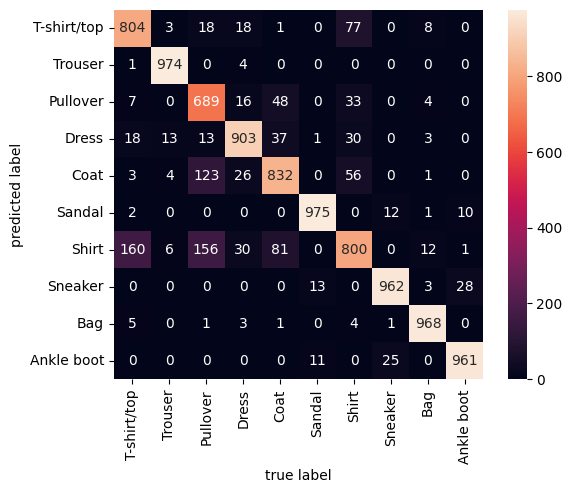

[450]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.87      0.72      0.79      1000
           3       0.87      0.93      0.90      1000
           4       0.74      0.88      0.80      1000
           5       0.98      0.97      0.97      1000
           6       0.70      0.72      0.71      1000
           7       0.92      0.98      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



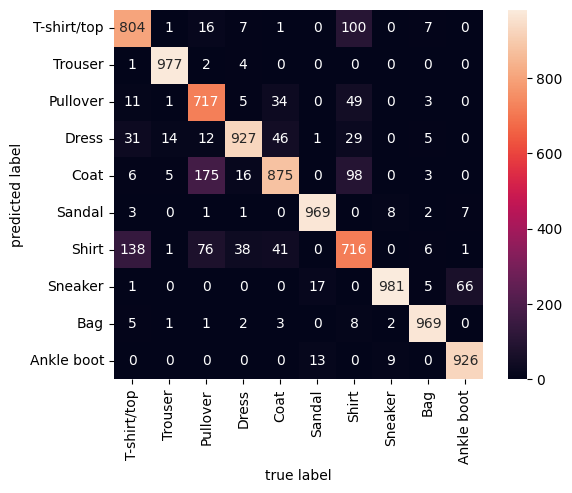

[460]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.84      0.73      0.78      1000
           3       0.85      0.94      0.90      1000
           4       0.71      0.89      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.79      0.59      0.67      1000
           7       0.96      0.94      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



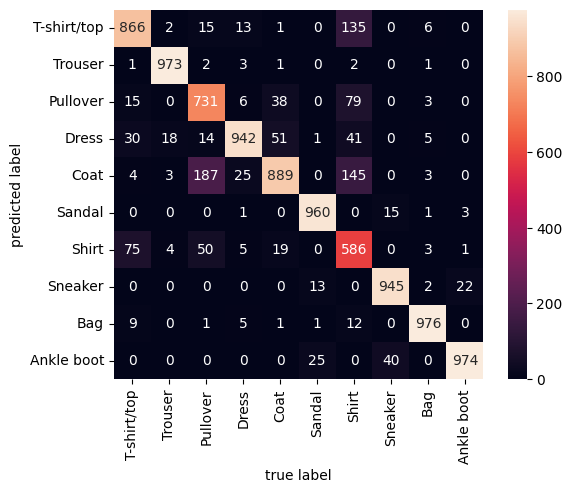

[470]
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1000
           1       0.98      0.99      0.98      1000
           2       0.83      0.72      0.77      1000
           3       0.91      0.90      0.90      1000
           4       0.75      0.89      0.81      1000
           5       0.99      0.97      0.98      1000
           6       0.68      0.76      0.71      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



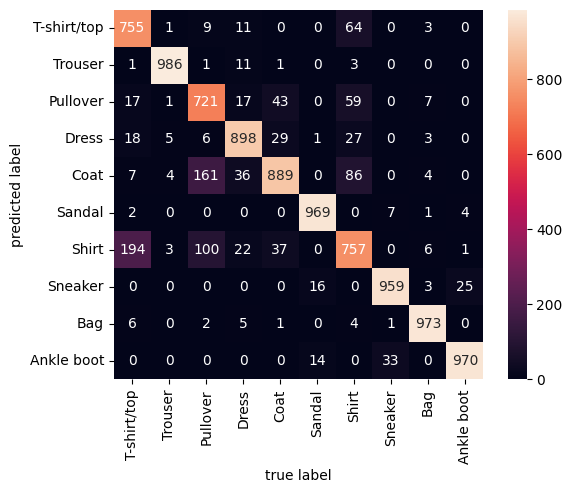

[480]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1000
           1       1.00      0.97      0.99      1000
           2       0.87      0.73      0.79      1000
           3       0.87      0.93      0.90      1000
           4       0.77      0.84      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.66      0.69      1000
           7       0.91      0.98      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.98      0.93      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



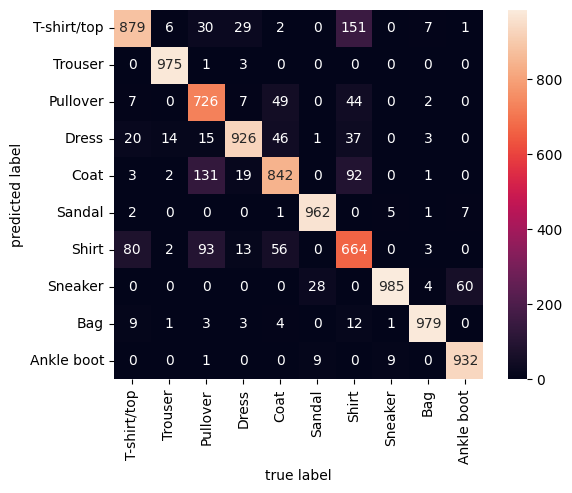

[490]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.97      0.99      0.98      1000
           2       0.84      0.74      0.79      1000
           3       0.91      0.90      0.90      1000
           4       0.69      0.92      0.79      1000
           5       0.99      0.96      0.98      1000
           6       0.79      0.58      0.67      1000
           7       0.91      0.99      0.94      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.92      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



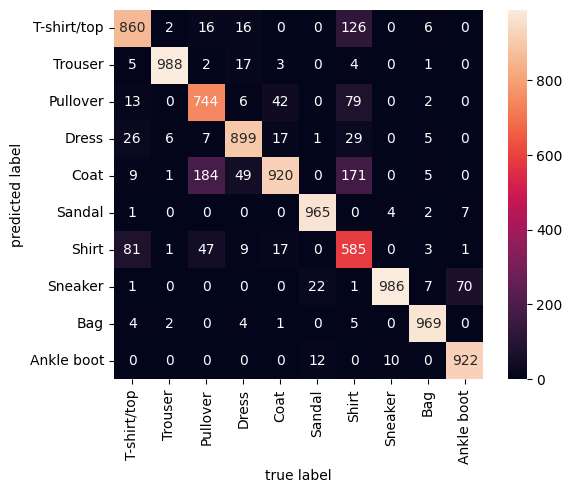

[500]
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.72      0.79      1000
           3       0.88      0.94      0.91      1000
           4       0.82      0.82      0.82      1000
           5       0.99      0.96      0.98      1000
           6       0.63      0.82      0.71      1000
           7       0.91      0.99      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.92      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



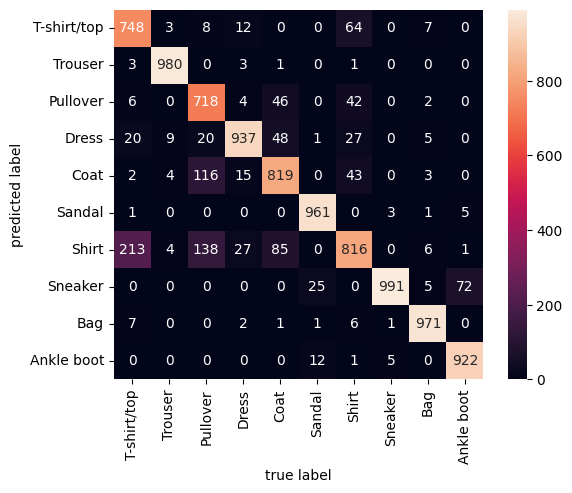

[510]
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1000
           1       0.99      0.97      0.98      1000
           2       0.85      0.73      0.79      1000
           3       0.93      0.86      0.89      1000
           4       0.79      0.83      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.60      0.81      0.69      1000
           7       0.91      0.99      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



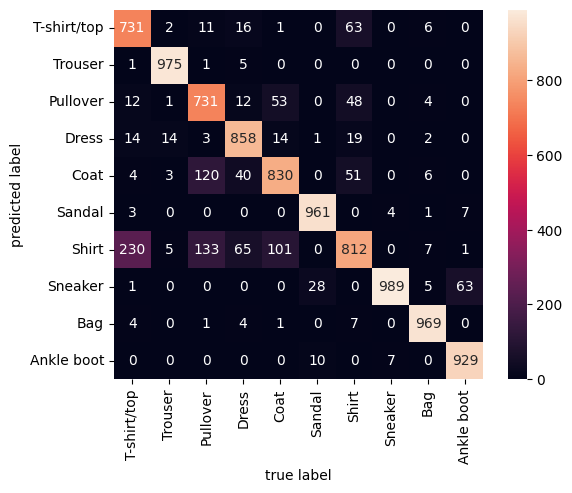

[520]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       1.00      0.98      0.99      1000
           2       0.82      0.79      0.81      1000
           3       0.93      0.88      0.90      1000
           4       0.84      0.77      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.66      0.76      0.70      1000
           7       0.90      0.99      0.94      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.92      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



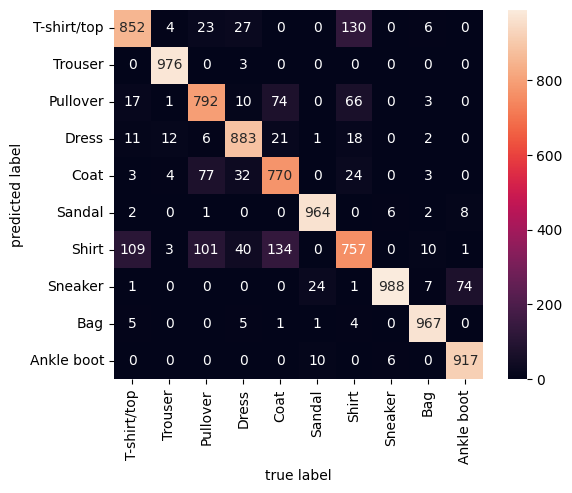

[530]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.76      0.79      0.77      1000
           3       0.95      0.82      0.88      1000
           4       0.74      0.85      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.74      0.65      0.69      1000
           7       0.93      0.98      0.95      1000
           8       0.99      0.95      0.97      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



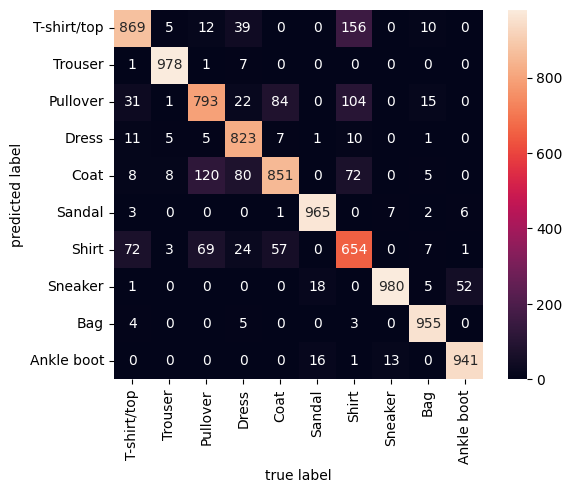

[540]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.79      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.73      0.90      0.80      1000
           5       0.98      0.97      0.98      1000
           6       0.77      0.65      0.71      1000
           7       0.96      0.94      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.94      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



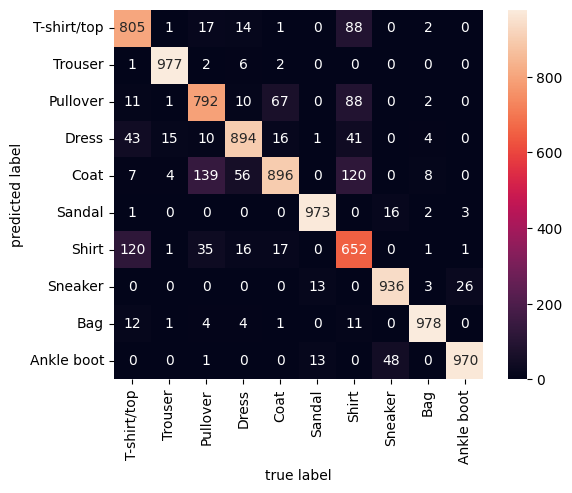

[550]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.83      0.81      1000
           3       0.91      0.89      0.90      1000
           4       0.82      0.83      0.83      1000
           5       0.99      0.96      0.97      1000
           6       0.77      0.63      0.70      1000
           7       0.93      0.98      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



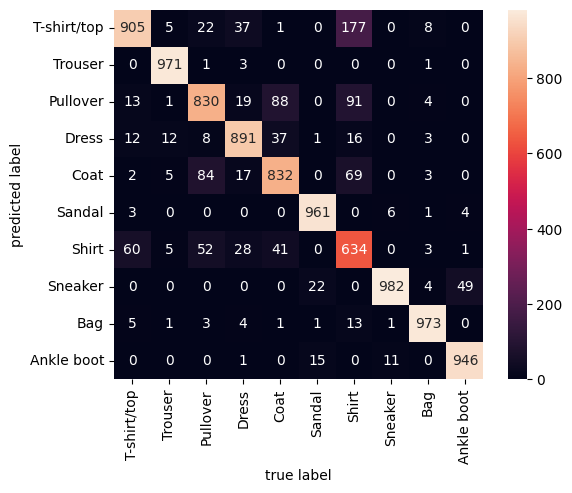

[560]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       0.98      0.99      0.98      1000
           2       0.82      0.80      0.81      1000
           3       0.91      0.90      0.90      1000
           4       0.78      0.87      0.82      1000
           5       0.98      0.97      0.98      1000
           6       0.78      0.65      0.71      1000
           7       0.95      0.98      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



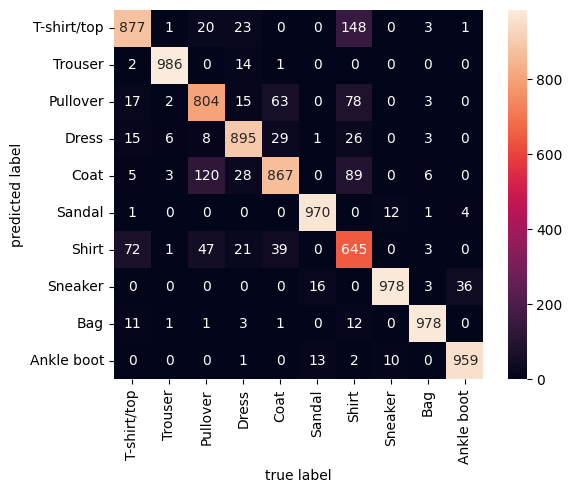

[570]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.82      0.80      0.81      1000
           3       0.89      0.93      0.91      1000
           4       0.82      0.82      0.82      1000
           5       0.98      0.97      0.98      1000
           6       0.71      0.75      0.73      1000
           7       0.96      0.96      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



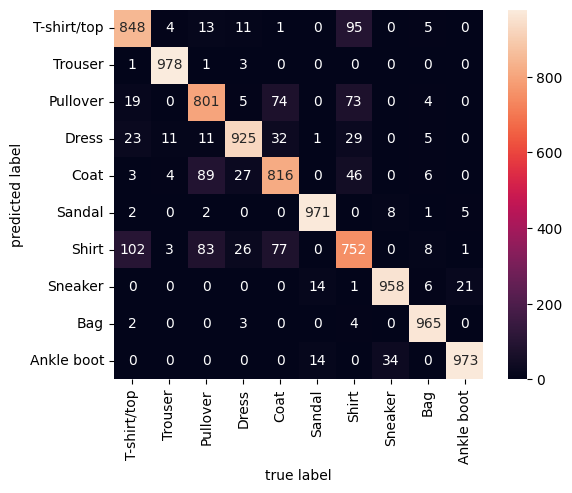

[580]
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.66      0.76      1000
           3       0.90      0.90      0.90      1000
           4       0.74      0.86      0.80      1000
           5       0.99      0.96      0.97      1000
           6       0.60      0.82      0.69      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



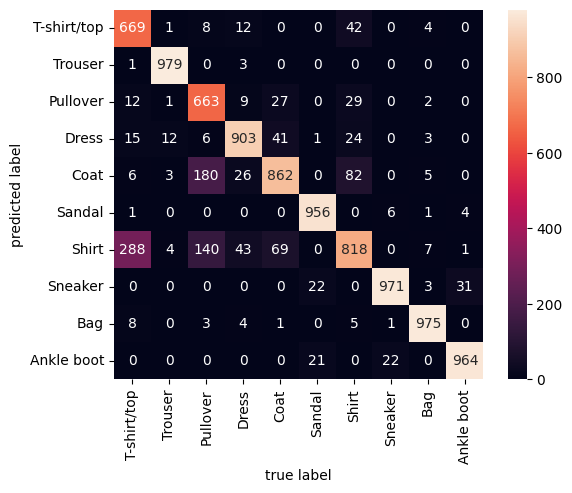

[590]
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1000
           1       1.00      0.97      0.98      1000
           2       0.75      0.87      0.80      1000
           3       0.91      0.89      0.90      1000
           4       0.84      0.78      0.81      1000
           5       0.98      0.97      0.98      1000
           6       0.69      0.73      0.71      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



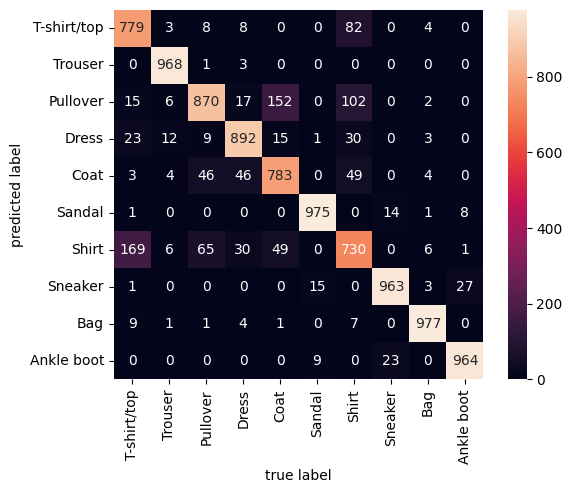

[600]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       1.00      0.98      0.99      1000
           2       0.86      0.73      0.79      1000
           3       0.90      0.91      0.91      1000
           4       0.73      0.88      0.80      1000
           5       0.99      0.97      0.98      1000
           6       0.74      0.69      0.71      1000
           7       0.96      0.96      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



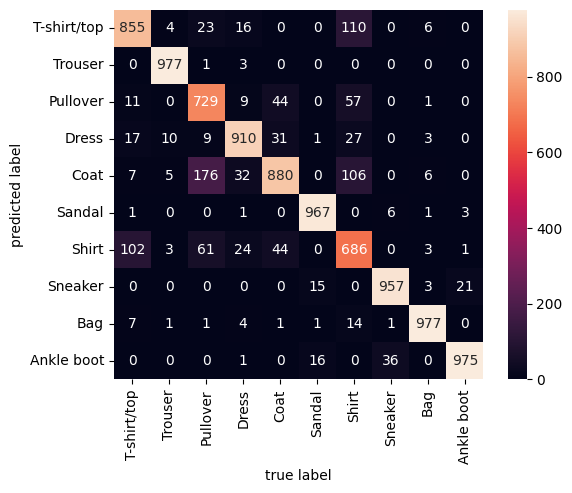

[610]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.72      0.88      0.79      1000
           3       0.94      0.84      0.89      1000
           4       0.84      0.76      0.79      1000
           5       0.99      0.95      0.97      1000
           6       0.73      0.71      0.72      1000
           7       0.96      0.95      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.93      0.98      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



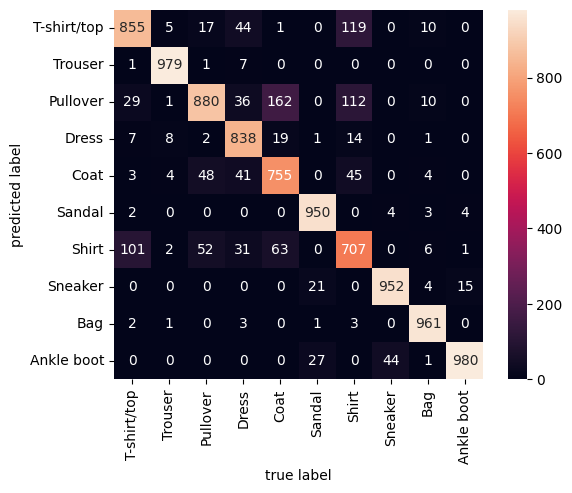

[620]
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.88      0.92      0.90      1000
           4       0.90      0.70      0.78      1000
           5       0.99      0.97      0.98      1000
           6       0.62      0.82      0.71      1000
           7       0.91      0.98      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.92      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



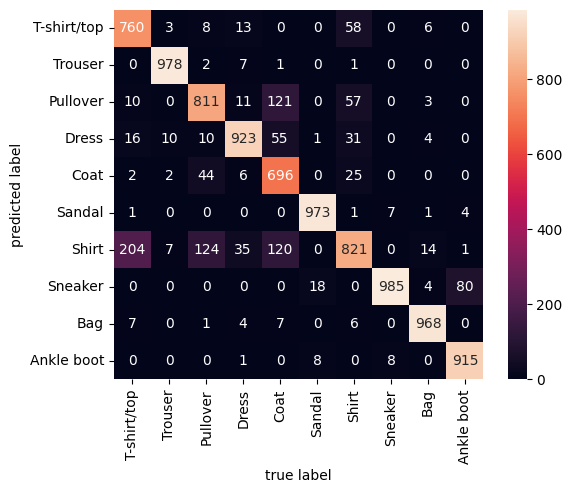

[630]
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.76      0.79      1000
           3       0.92      0.88      0.90      1000
           4       0.72      0.91      0.80      1000
           5       0.99      0.97      0.98      1000
           6       0.75      0.64      0.69      1000
           7       0.95      0.98      0.97      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



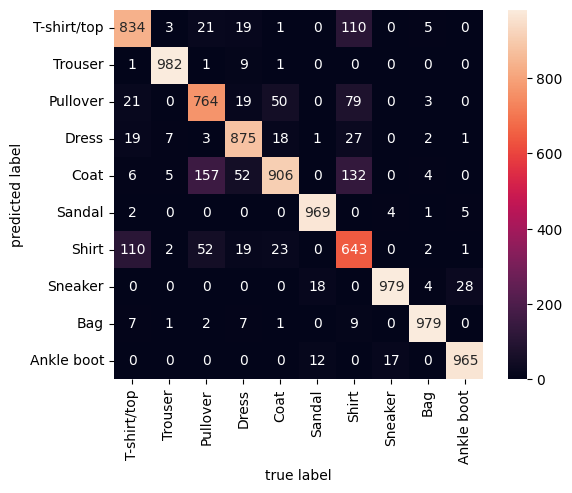

[640]
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.83      0.71      0.77      1000
           3       0.89      0.90      0.90      1000
           4       0.69      0.93      0.79      1000
           5       0.99      0.96      0.97      1000
           6       0.76      0.65      0.70      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



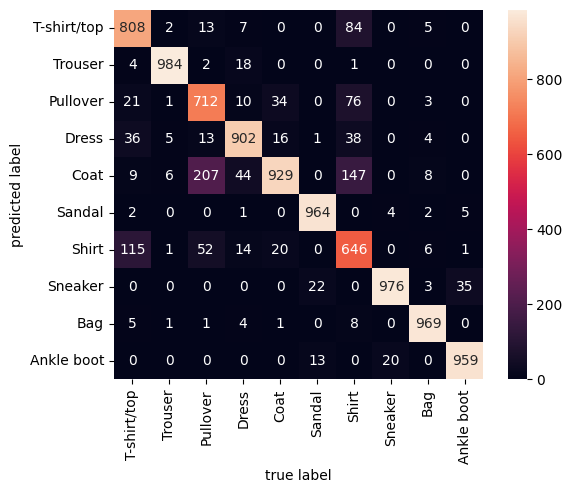

[650]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.85      0.77      0.81      1000
           3       0.91      0.91      0.91      1000
           4       0.79      0.88      0.83      1000
           5       0.98      0.98      0.98      1000
           6       0.73      0.69      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



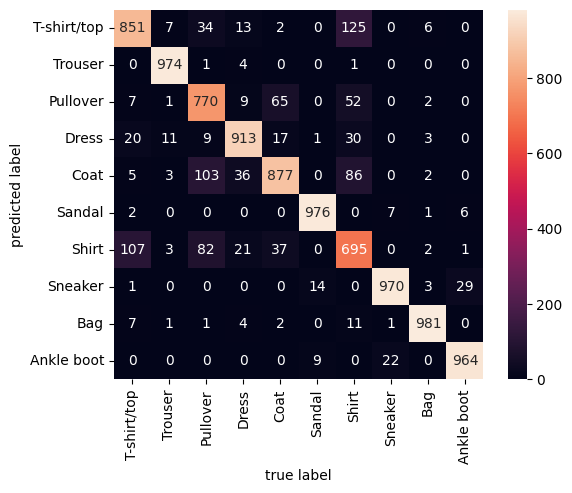

[660]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.86      0.71      0.78      1000
           3       0.91      0.90      0.90      1000
           4       0.75      0.88      0.81      1000
           5       0.98      0.97      0.98      1000
           6       0.69      0.70      0.70      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



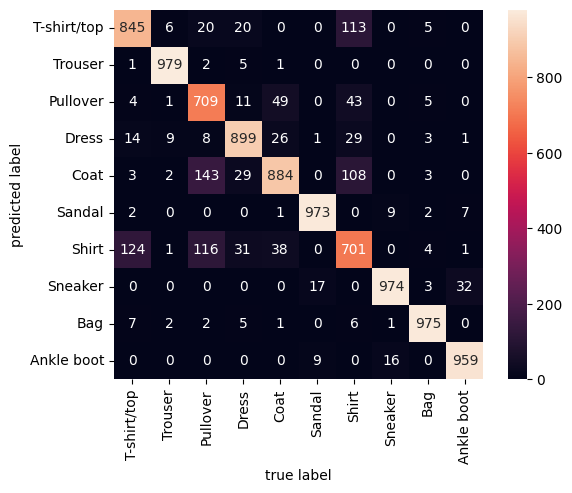

[670]
              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.83      0.77      0.80      1000
           3       0.93      0.88      0.91      1000
           4       0.77      0.85      0.81      1000
           5       0.99      0.97      0.98      1000
           6       0.75      0.70      0.72      1000
           7       0.96      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



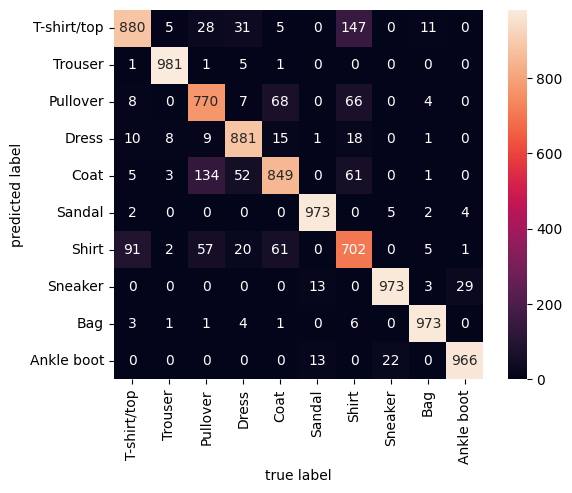

[680]
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.70      0.88      0.78      1000
           3       0.92      0.89      0.90      1000
           4       0.77      0.82      0.80      1000
           5       0.98      0.98      0.98      1000
           6       0.90      0.46      0.60      1000
           7       0.95      0.97      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



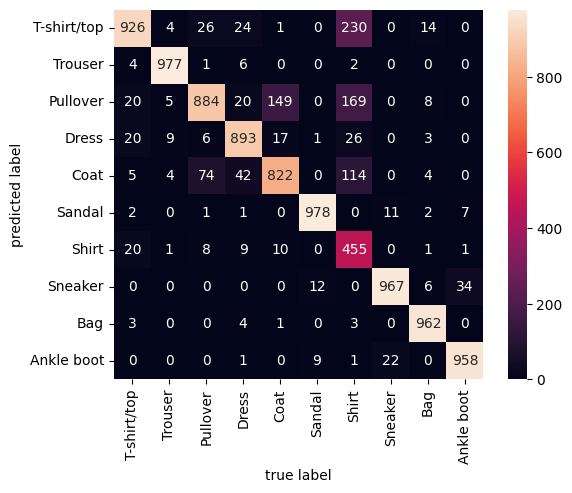

[690]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.75      0.79      1000
           3       0.92      0.90      0.91      1000
           4       0.74      0.91      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.71      0.71      0.71      1000
           7       0.94      0.98      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



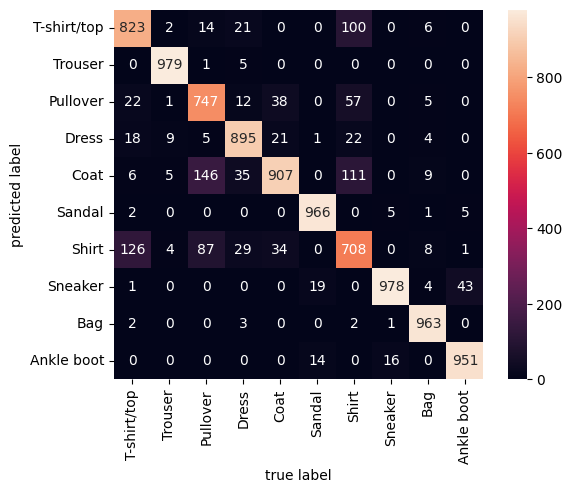

[700]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1000
           1       1.00      0.98      0.99      1000
           2       0.78      0.80      0.79      1000
           3       0.88      0.93      0.90      1000
           4       0.81      0.80      0.80      1000
           5       0.95      0.99      0.97      1000
           6       0.80      0.59      0.68      1000
           7       0.96      0.94      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



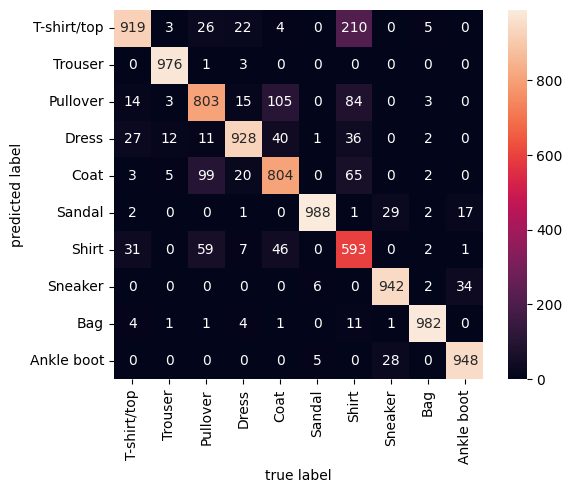

[710]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.69      0.76      1000
           3       0.93      0.88      0.90      1000
           4       0.69      0.92      0.79      1000
           5       0.99      0.96      0.98      1000
           6       0.78      0.64      0.70      1000
           7       0.94      0.98      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



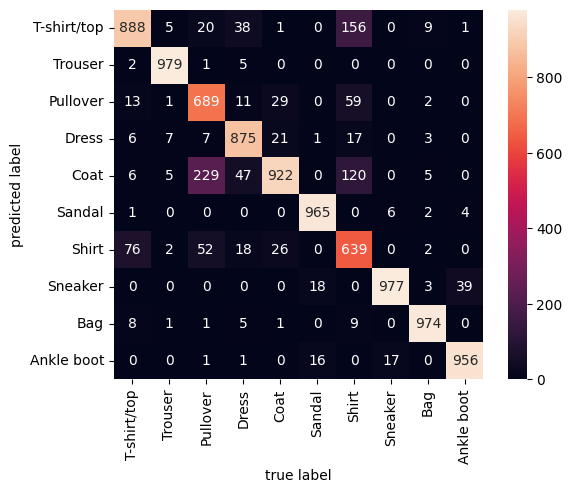

[720]
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.78      0.81      0.79      1000
           3       0.92      0.87      0.90      1000
           4       0.75      0.87      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.66      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



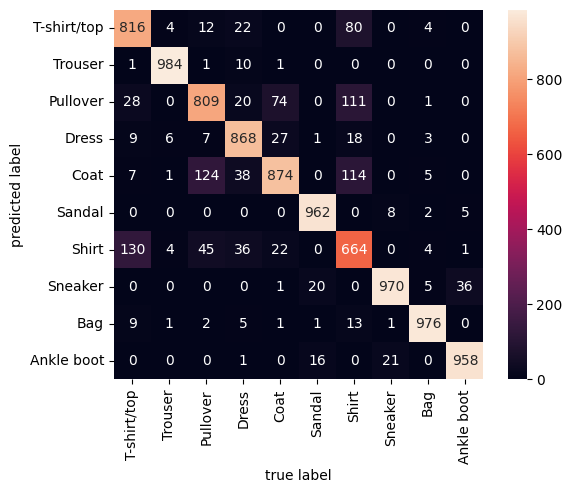

[730]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.74      0.88      0.80      1000
           3       0.92      0.90      0.91      1000
           4       0.82      0.80      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.75      0.69      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



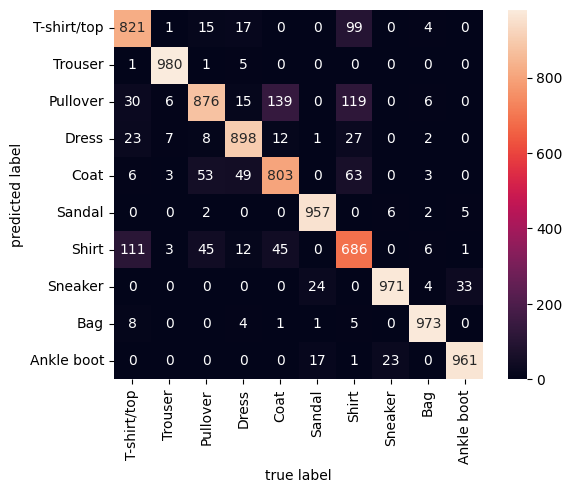

[740]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       1.00      0.97      0.99      1000
           2       0.85      0.76      0.80      1000
           3       0.91      0.89      0.90      1000
           4       0.79      0.83      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.70      0.74      0.72      1000
           7       0.92      0.98      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.93      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



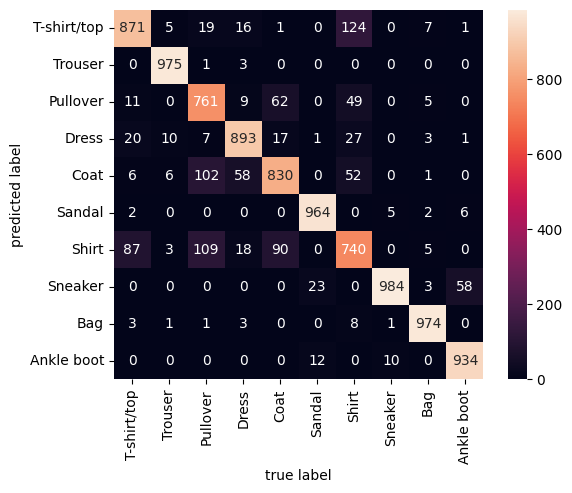

[750]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1000
           1       1.00      0.97      0.99      1000
           2       0.78      0.84      0.81      1000
           3       0.94      0.89      0.91      1000
           4       0.83      0.78      0.80      1000
           5       0.98      0.97      0.97      1000
           6       0.74      0.70      0.72      1000
           7       0.95      0.97      0.96      1000
           8       0.99      0.97      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



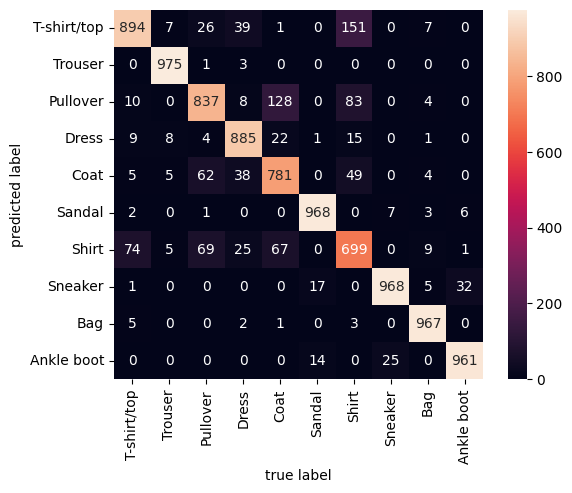

[760]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.78      0.84      0.81      1000
           3       0.93      0.90      0.91      1000
           4       0.79      0.83      0.81      1000
           5       0.99      0.97      0.98      1000
           6       0.77      0.68      0.72      1000
           7       0.97      0.95      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.94      0.98      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



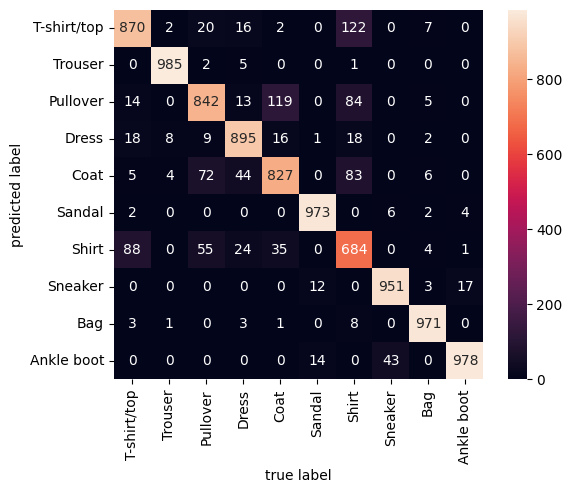

[770]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.71      0.89      0.79      1000
           3       0.93      0.87      0.90      1000
           4       0.79      0.80      0.79      1000
           5       0.98      0.97      0.97      1000
           6       0.76      0.64      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



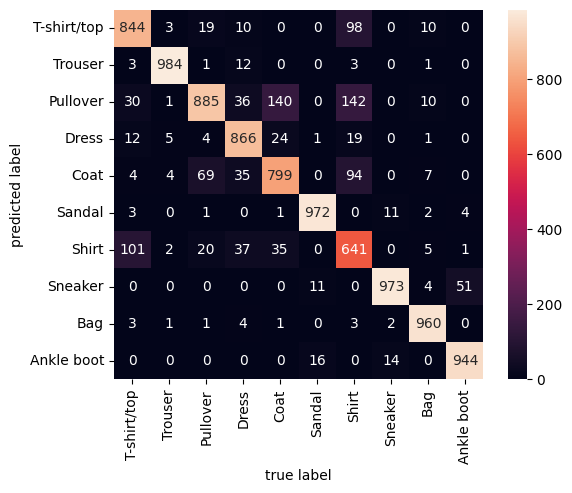

[780]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1000
           1       1.00      0.98      0.99      1000
           2       0.81      0.85      0.83      1000
           3       0.89      0.93      0.91      1000
           4       0.81      0.84      0.83      1000
           5       0.98      0.97      0.98      1000
           6       0.79      0.62      0.70      1000
           7       0.95      0.98      0.96      1000
           8       0.99      0.97      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



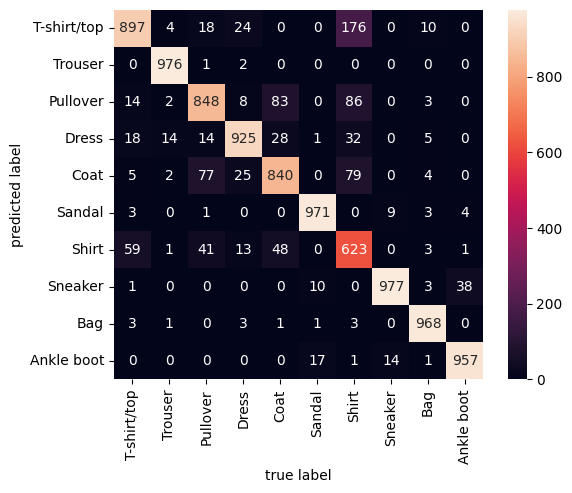

[790]
              precision    recall  f1-score   support

           0       0.80      0.89      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.73      0.88      0.80      1000
           3       0.92      0.89      0.90      1000
           4       0.78      0.82      0.80      1000
           5       0.97      0.97      0.97      1000
           6       0.81      0.54      0.65      1000
           7       0.97      0.93      0.95      1000
           8       0.95      0.98      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000



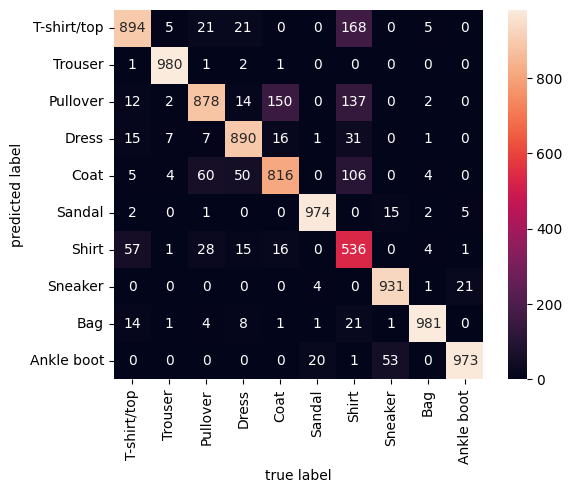

[800]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.74      0.80      1000
           3       0.90      0.91      0.90      1000
           4       0.75      0.90      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.65      0.70      1000
           7       0.94      0.97      0.96      1000
           8       0.99      0.91      0.95      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



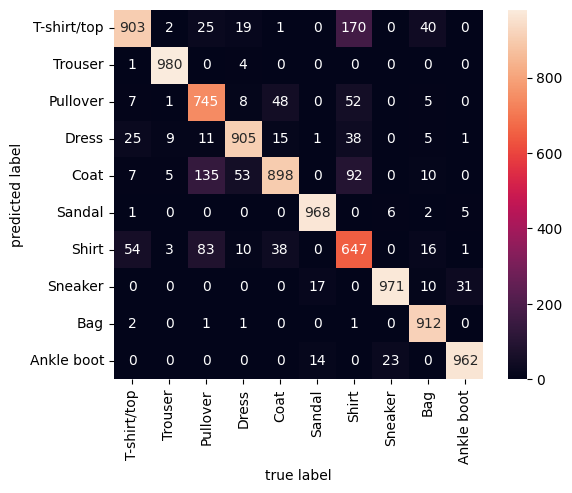

[810]
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.70      0.89      0.79      1000
           3       0.93      0.87      0.90      1000
           4       0.83      0.75      0.79      1000
           5       0.98      0.97      0.98      1000
           6       0.83      0.60      0.69      1000
           7       0.93      0.98      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000



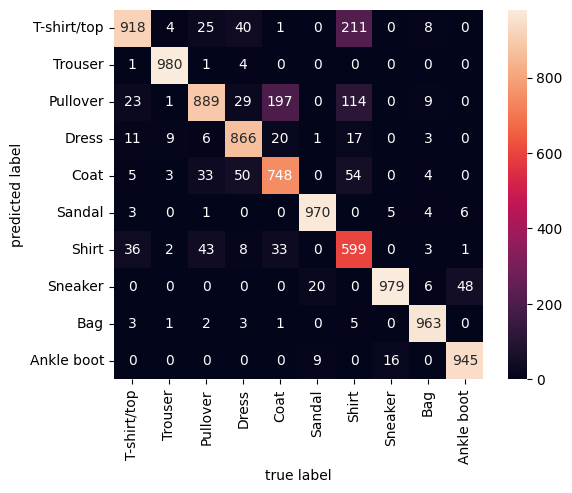

[820]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       1.00      0.97      0.98      1000
           2       0.81      0.82      0.81      1000
           3       0.93      0.87      0.90      1000
           4       0.77      0.88      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.65      0.70      1000
           7       0.93      0.98      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



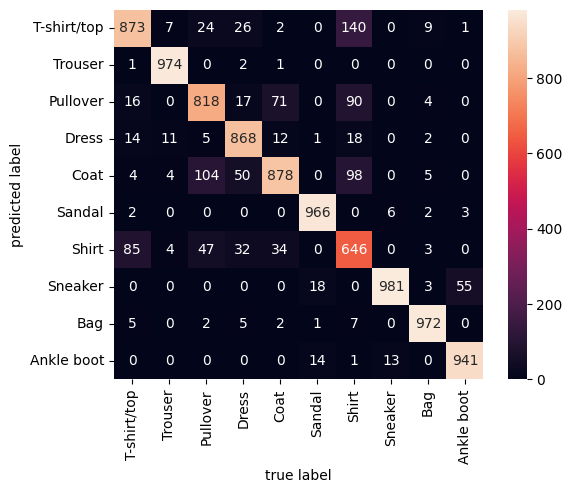

[830]
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.76      0.87      0.81      1000
           3       0.92      0.91      0.91      1000
           4       0.79      0.82      0.81      1000
           5       0.98      0.97      0.97      1000
           6       0.83      0.58      0.69      1000
           7       0.90      0.99      0.94      1000
           8       0.99      0.97      0.98      1000
           9       0.99      0.91      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



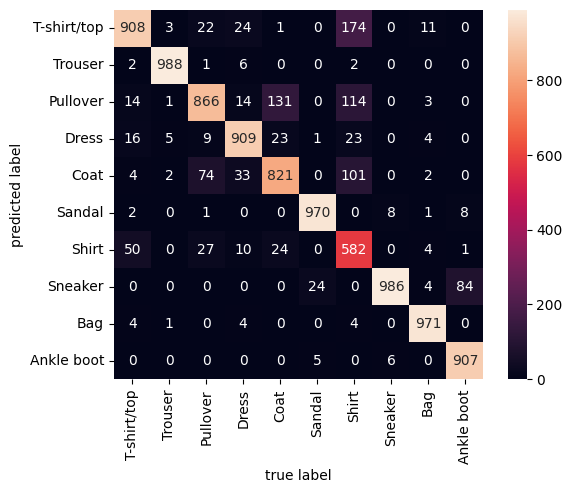

[840]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.79      0.83      0.81      1000
           3       0.89      0.92      0.90      1000
           4       0.83      0.80      0.82      1000
           5       0.98      0.97      0.97      1000
           6       0.71      0.72      0.71      1000
           7       0.96      0.96      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



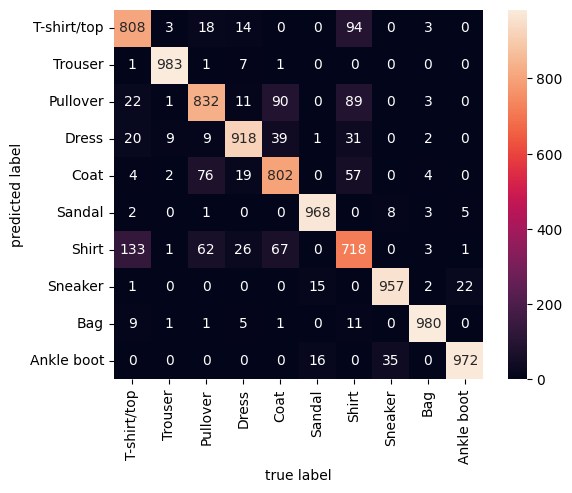

[850]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.62      0.73      1000
           3       0.93      0.89      0.91      1000
           4       0.70      0.89      0.78      1000
           5       0.99      0.96      0.97      1000
           6       0.69      0.75      0.72      1000
           7       0.96      0.96      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



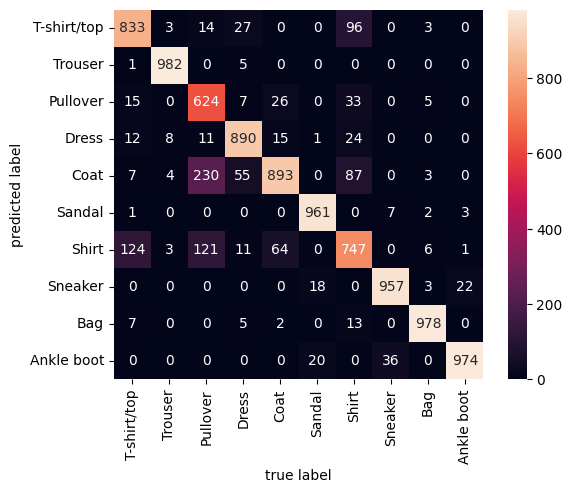

[860]
              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1000
           1       1.00      0.97      0.98      1000
           2       0.78      0.81      0.79      1000
           3       0.93      0.84      0.89      1000
           4       0.80      0.81      0.81      1000
           5       0.98      0.97      0.97      1000
           6       0.71      0.66      0.68      1000
           7       0.95      0.98      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



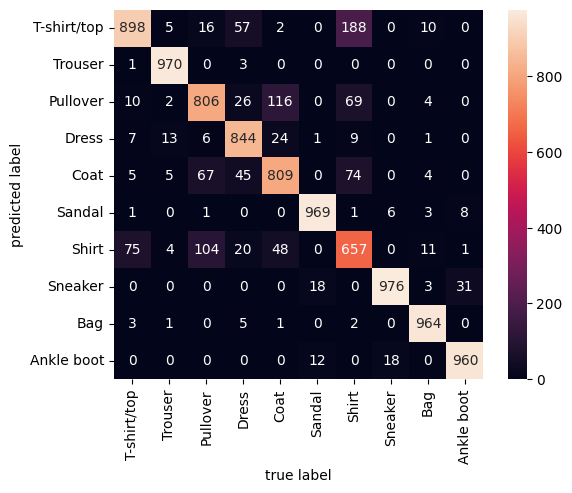

[870]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.78      0.82      0.80      1000
           3       0.94      0.88      0.90      1000
           4       0.74      0.89      0.81      1000
           5       0.98      0.98      0.98      1000
           6       0.74      0.66      0.70      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



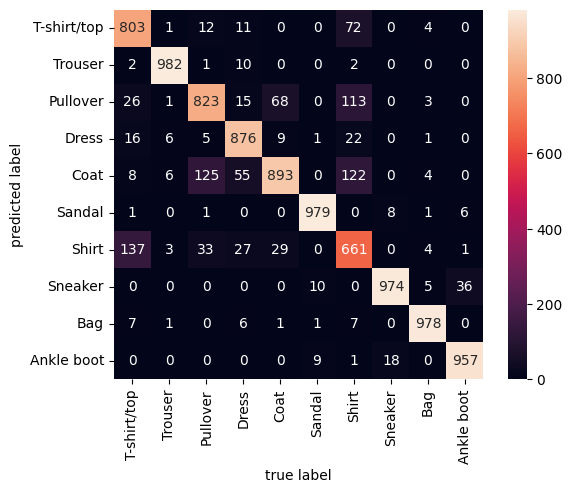

[880]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.98      0.98      0.98      1000
           2       0.82      0.76      0.79      1000
           3       0.89      0.90      0.90      1000
           4       0.77      0.85      0.81      1000
           5       0.98      0.98      0.98      1000
           6       0.73      0.71      0.72      1000
           7       0.97      0.95      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.95      0.98      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



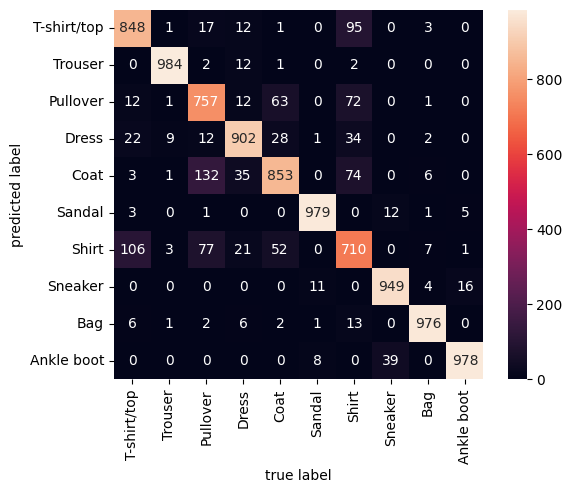

[890]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1000
           1       1.00      0.98      0.99      1000
           2       0.87      0.62      0.73      1000
           3       0.88      0.90      0.89      1000
           4       0.62      0.94      0.75      1000
           5       0.98      0.97      0.98      1000
           6       0.75      0.61      0.67      1000
           7       0.97      0.93      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.93      0.98      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



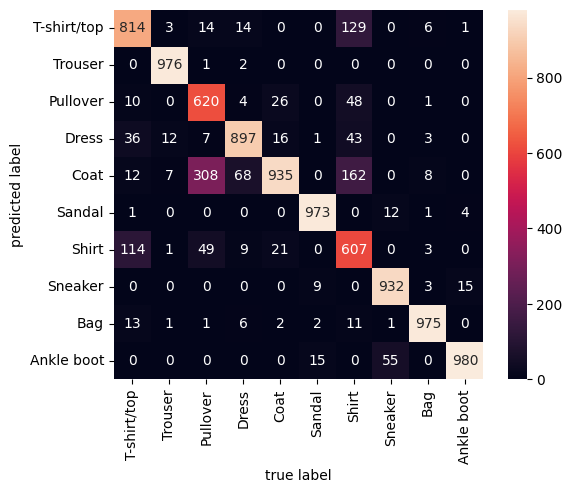

[900]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1000
           1       1.00      0.97      0.98      1000
           2       0.75      0.87      0.81      1000
           3       0.85      0.94      0.89      1000
           4       0.86      0.75      0.80      1000
           5       0.98      0.97      0.97      1000
           6       0.81      0.64      0.72      1000
           7       0.97      0.94      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.95      0.98      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



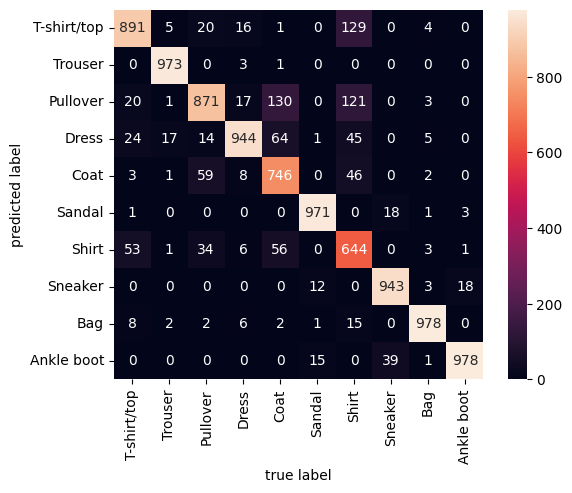

[910]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.76      0.88      0.81      1000
           3       0.91      0.88      0.90      1000
           4       0.88      0.73      0.80      1000
           5       0.98      0.97      0.98      1000
           6       0.72      0.73      0.73      1000
           7       0.94      0.98      0.96      1000
           8       0.99      0.97      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



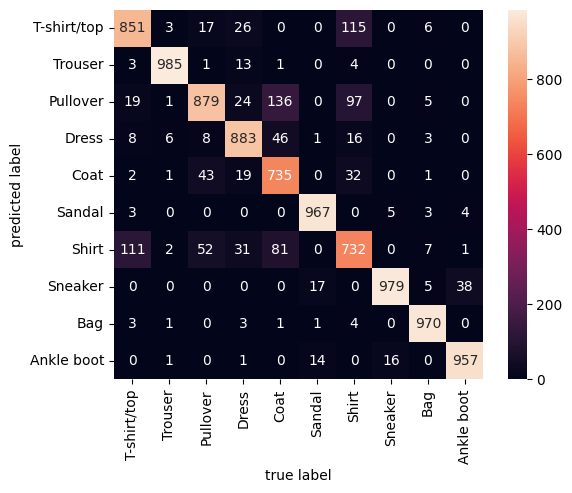

[920]
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.80      0.84      0.82      1000
           3       0.90      0.92      0.91      1000
           4       0.84      0.80      0.82      1000
           5       0.98      0.98      0.98      1000
           6       0.68      0.77      0.72      1000
           7       0.97      0.97      0.97      1000
           8       0.98      0.97      0.97      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



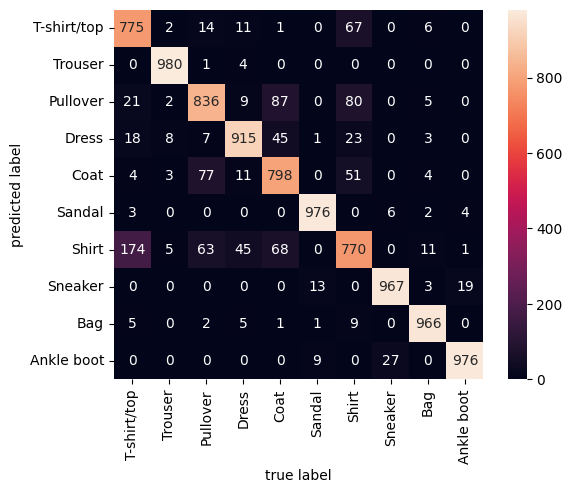

[930]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.73      0.80      1000
           3       0.91      0.91      0.91      1000
           4       0.76      0.89      0.82      1000
           5       0.99      0.95      0.97      1000
           6       0.74      0.69      0.71      1000
           7       0.93      0.98      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



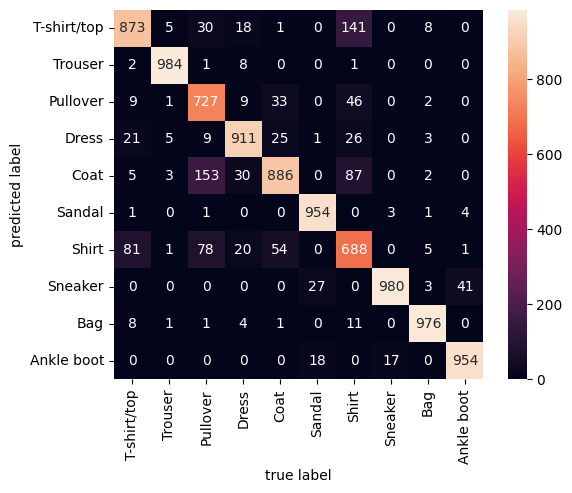

[940]
              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.60      0.71      1000
           3       0.91      0.89      0.90      1000
           4       0.71      0.90      0.79      1000
           5       0.98      0.97      0.97      1000
           6       0.60      0.78      0.68      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.87     10000



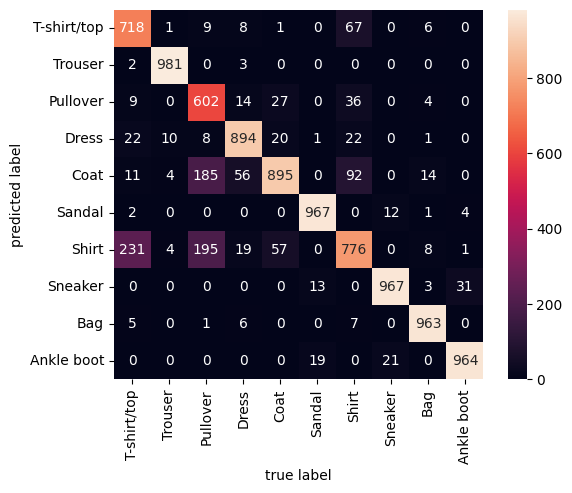

[950]
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1000
           1       0.99      0.98      0.98      1000
           2       0.78      0.82      0.80      1000
           3       0.93      0.88      0.90      1000
           4       0.75      0.88      0.81      1000
           5       0.99      0.96      0.98      1000
           6       0.68      0.72      0.70      1000
           7       0.95      0.96      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



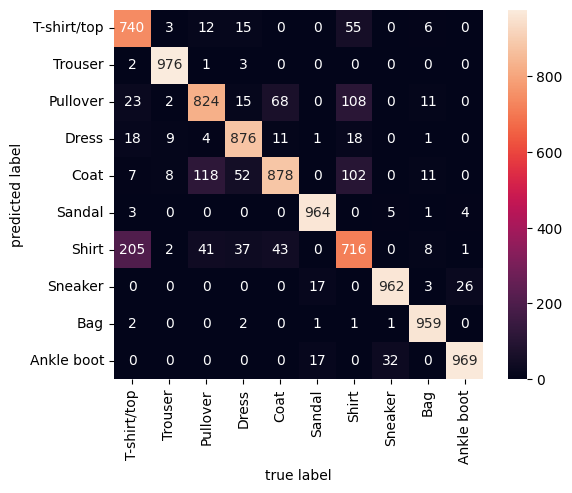

[960]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.92      0.99      0.95      1000
           2       0.75      0.84      0.79      1000
           3       0.93      0.84      0.88      1000
           4       0.79      0.80      0.80      1000
           5       0.99      0.96      0.98      1000
           6       0.76      0.64      0.69      1000
           7       0.96      0.95      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.98      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



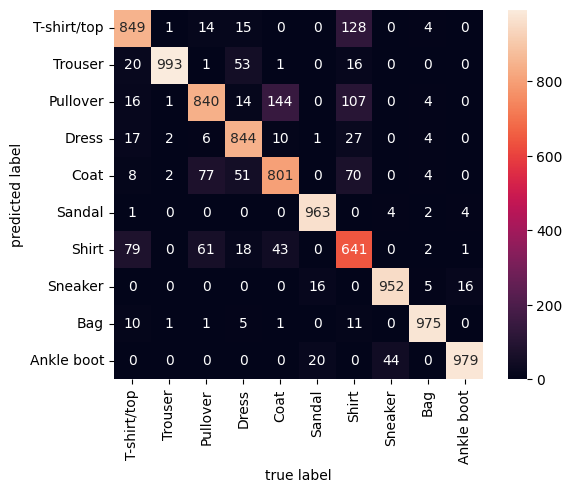

[970]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.81      0.81      0.81      1000
           3       0.94      0.85      0.89      1000
           4       0.84      0.82      0.83      1000
           5       0.98      0.97      0.98      1000
           6       0.71      0.72      0.72      1000
           7       0.96      0.97      0.97      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



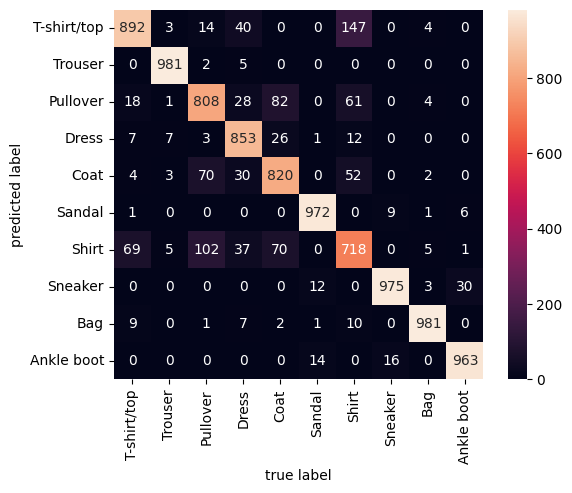

[980]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.81      0.79      0.80      1000
           3       0.88      0.92      0.90      1000
           4       0.84      0.78      0.81      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.69      0.70      1000
           7       0.92      0.98      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.98      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



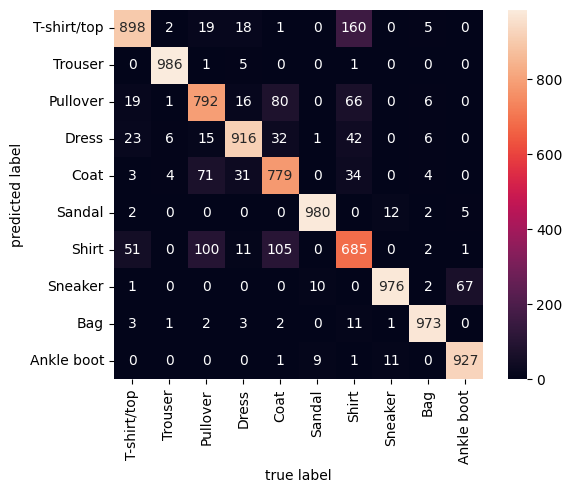

[990]
              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1000
           1       1.00      0.98      0.99      1000
           2       0.68      0.92      0.78      1000
           3       0.89      0.93      0.91      1000
           4       0.86      0.71      0.78      1000
           5       0.98      0.96      0.97      1000
           6       0.81      0.56      0.67      1000
           7       0.94      0.98      0.96      1000
           8       0.99      0.96      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



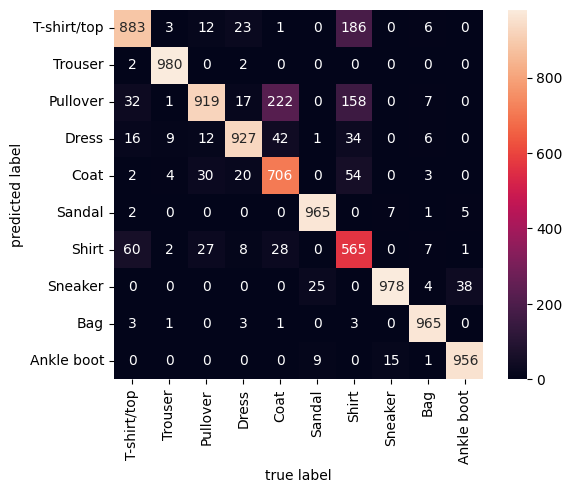

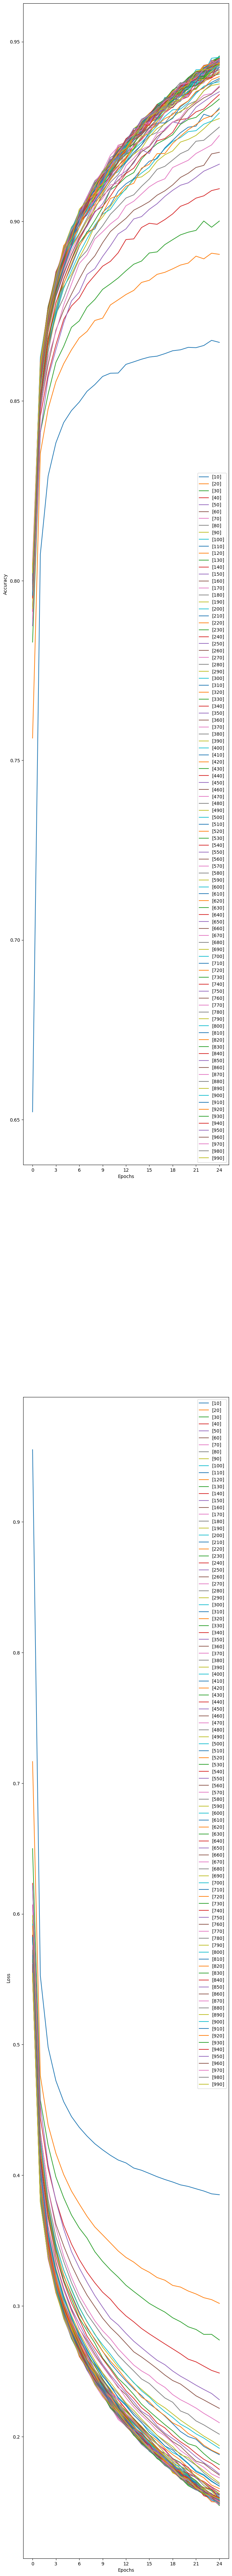

Best model:  [180]
Stable model:  [350]


In [31]:
models = np.reshape(np.arange(10, 1000, 10), (-1, 1))

best_model, stable_model = build_and_evaluate_models_threading(models)
print('Best model: ', models[best_model])
print('Stable model: ', models[stable_model])

In [27]:
# models = np.reshape(np.arange(10, 1000, 10), (-1, 1))

# best_model, stable_model = build_and_evaluate_models(models)
# print('Best model: ', models[best_model])
# print('Stable model: ', models[stable_model])


# models = np.reshape(np.arange(10, 50, 1), (-1, 1))

# best_model, stable_model = build_and_evaluate_models([[], [10], [20]])
# print('Best model: ', models[best_model])
# print('Stable model: ', models[stable_model])

It is interesting to see that where it got confused is between similar items. The shirt is mainly confused with T-shirt/top, pullover, coat, and dress. All of these are, for the most part, the same shape and reflects in the precision and recall values; they are the lowest across the board. On the other hand, the item with the best scores is the most unique out of the list, trousers.